In [1]:
'''
filepath will point to current location of the Jupyter Notebook. Creates a folder for downloading data into, and another for figures.
'''
import os
from os import path
os.getcwd()
!pwd
if not os.path.exists('data'):
    os.mkdir('data')
else:
    print("'data' directory already exists'")
if not os.path.exists('figures'):
    os.mkdir('figures')
else:
    print("'figures' directory already exists'")
if not os.path.exists('work_dir'):
    os.mkdir('work_dir')
else:
    print("'work_dir' directory already exists'")
work_dir = os.path.expanduser('work_dir')
filepath = os.getcwd()

/Users/jamiefarquharson/Desktop/RSMAS/Eruption_ntbk
'data' directory already exists'
'figures' directory already exists'
'work_dir' directory already exists'


In [111]:
'''
Import packages
'''
from netCDF4 import Dataset
import numpy as np
import geopandas as gpd

import matplotlib as matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.ticker as ticker
from matplotlib import patheffects, rc, rcParams
import matplotlib.dates as mdates
from matplotlib.patches import ConnectionPatch, Polygon
from matplotlib.ticker import LogFormatterExponent
import matplotlib.font_manager as font_manager

plt.rcParams["font.family"] = 'serif'
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Computer Modern Sans serif']
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Palatino']
params = {'text.latex.preamble' : [r'\usepackage{amsmath}', r'\usepackage{amssymb}']}
plt.rcParams.update(params)
rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('text', usetex=True)

from datetime import datetime, timedelta
import datetime as dt

import pandas as pd
import calendar

from mintpy.simulation.plot import *
from mintpy.objects import sensor
from mintpy.utils import readfile, plot as pp, utils as ut
from mintpy import view

import string as STRING

from scipy.sparse import diags
import pylab

import random
from decimal import Decimal
from scipy import math as math

import warnings
warnings.filterwarnings('ignore')

print("All packages imported")

All packages imported


In [112]:
'''
Function converts mm input to inches (for plotting figures the correct size).
'''

def mm2inch(*tupl):
    if isinstance(tupl[0], tuple):
        return tuple(k*0.0393701 for k in tupl[0])
    else:
        return tuple(k*0.0393701 for k in tupl)

'''
Defines a few colours used later
'''
vir_b = plt.cm.viridis_r(255)
vir_g = plt.cm.viridis_r(127.5)
vir_y = plt.cm.viridis_r(0)

'''
For formatting logarithmic axis labels
'''
class LogFormatterTexTextMode(LogFormatterExponent):
    def __call__(self, x, pos=None):
        x = LogFormatterExponent.__call__(self, x,pos)
        s = r"10\textsuperscript{{{}}}".format(x)
        return s
    
'''
Calculates the factorial of a given number
'''    
def fact(x):
    return Decimal(math.factorial(x))

In [4]:
'''
Generate 'data_url.txt' file with list of urls required for data download. The default is to download all data from 01 Mar 2000 up until yesterday. 
A window of dates can be entered instead, for example: 

data_range(first=dt.date(2018, 12, 15), last=dt.date(2018,12,18))

'''
if os.getcwd() != filepath+'/data':
    %cd $filepath/data

prefix = 'https://disc2.gesdisc.eosdis.nasa.gov/data/TRMM_RT/TRMM_3B42RT_Daily.7/'

suffix = '.7.nc4\n'

yesterday = dt.date.today() - timedelta(1)

start_date = dt.date(2000, 3, 1)
end_date = dt.date(2019, 12, 31)

def data_range_string(first = None, last = end_date):
    data_dates = last - first
    for j in range(data_dates.days + 1):
        yield (first + timedelta(days = j)).strftime('%Y/%m')+'/3B42RT_Daily.'+(first + timedelta(days = j)).strftime('%Y%m%d')


string_list = list(data_range_string(first = start_date))#, last=dt.date(2018,12,18)))

with open("data_url.txt", "w") as output:
    for line in list([ prefix+x+suffix for x in string_list ]):
        output.write(str(line))

/Users/jamiefarquharson/Desktop/RSMAS/Eruption_ntbk/data


**The TRMM/GPM satellite data is made freely available through NASA's GES Disc Portal.** 
*Citation*:

In [78]:
print("Tropical Rainfall Measuring Mission (TRMM) (2011),\nTRMM (TMPA) Rainfall Estimate L3 3 hour 0.25 degree x 0.25 degree V7, Greenbelt, MD, Goddard Earth Sciences Data and Information Services Center (GES DISC), Accessed: {},\ndoi: 10.5067/TRMM/TMPA/3H/7".format(dt.date.today()))

Tropical Rainfall Measuring Mission (TRMM) (2011),
TRMM (TMPA) Rainfall Estimate L3 3 hour 0.25 degree x 0.25 degree V7, Greenbelt, MD, Goddard Earth Sciences Data and Information Services Center (GES DISC), Accessed: 2020-02-03,
doi: 10.5067/TRMM/TMPA/3H/7


In [5]:
'''
Access and download data files specified in data_url using wget. Will skip previously downloaded files.

Note: despite -nv, will be verbose if large number of new datafiles are being accessed. 
Right-click on cell and Enable Scrolling for Outputs, if necessary. One can change -nv to -q, but it may be useful to have some output.
'''
if os.getcwd() != filepath+'/data':
    %cd $filepath/data
!wget -nv -i data_url.txt -nc -c 
print('Data retrieved')

Data retrieved


In [6]:
import datetime as dt
'''
Opens textfile with list of data urls. Removes useless characters and returns a list of filenames for later use, as well as a list of dates. 
'''
if os.getcwd() != filepath+'/data':
    %cd $filepath/data
datafile = 'data_url.txt'
f = open(datafile)
f.seek(0)
fileIDs = f.readlines()
f.close()
fileIDs = [line.rstrip('\n') for line in fileIDs]
fileIDs = [line.lstrip(prefix) for line in fileIDs]
file_list =[]
for j,k in enumerate(fileIDs):
    text = fileIDs[j]
    if text.endswith('nc4'):    # Only deals with files that are netcdf format
        file_list.append(fileIDs[j][7:])
    else:
        continue
file_names = []
for j,k in enumerate(file_list):
    file_names.append(file_list[j][13:21])
fd =[]
for j,k in enumerate(file_names):
    fd.append(file_names[j][0:4]+'-'+file_names[j][4:6]+'-'+file_names[j][6:])
file_dates = [dt.datetime.strptime(k, '%Y-%m-%d').date() for k in fd]
print("Dates available : {} to {}".format(file_dates[0], file_dates[-1]))

Dates available : 2000-03-01 to 2019-12-31


In [7]:
'''
Open netcdf files and extract information.
'''

if os.getcwd() != filepath+'/data':
    %cd $filepath/data
    
ncFid = Dataset(file_list[0],"r", format = "NETCDF4") # Open just the first file to extract latitude and longitude data
longitude = ncFid.variables['lon'][:]
latitude = ncFid.variables['lat'][:]
ncFid.close() # Close file once done

precipitation = [] # Create precipitation variable
start_dates = [] # Create date variable
m = -1
for j,k in enumerate(file_list): # Interrogates file_list as defined above
    ncFid = Dataset(file_list[j],"r", format = "NETCDF4")
    precipitation.append(np.transpose(ncFid.variables['precipitation'][:])) # Iteratively append precipitation data
    start_dates.append(np.transpose(ncFid.BeginDate)) # Iteratively append date information
    ncFid.close() # Close file before opening next
    if j % int(np.ceil(len(file_list)/100)) == 0:
        m += 1
        print('{:02d}% | '.format(np.arange(1,101)[m]), sep=' ', end=' ', flush=True)
file_dates = file_dates[0:len(precipitation)]
print("{} dates".format(len(precipitation)))        

01% |  02% |  03% |  04% |  05% |  06% |  07% |  08% |  09% |  10% |  11% |  12% |  13% |  14% |  15% |  16% |  17% |  18% |  19% |  20% |  21% |  22% |  23% |  24% |  25% |  26% |  27% |  28% |  29% |  30% |  31% |  32% |  33% |  34% |  35% |  36% |  37% |  38% |  39% |  40% |  41% |  42% |  43% |  44% |  45% |  46% |  47% |  48% |  49% |  50% |  51% |  52% |  53% |  54% |  55% |  56% |  57% |  58% |  59% |  60% |  61% |  62% |  63% |  64% |  65% |  66% |  67% |  68% |  69% |  70% |  71% |  72% |  73% |  74% |  75% |  76% |  77% |  78% |  79% |  80% |  81% |  82% |  83% |  84% |  85% |  86% |  87% |  88% |  89% |  90% |  91% |  92% |  93% |  94% |  95% |  96% |  97% |  98% |  99% |  100% |  7245 dates


In [8]:
'''
Accesses the most recent GVP volcanoes eruptions lists, saves them as csv files: "Holocene_volcanoes" and "Holocene_eruptions".
'''
!wget --no-check-certificate --output-document Holocene_eruptions.csv "https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=GVP_VOTW:Smithsonian_VOTW_Holocene_Eruptions&outputFormat=csv"
!wget --no-check-certificate --output-document Holocene_volcanoes.csv "https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=GVP_VOTW:Smithsonian_VOTW_Holocene_Volcanoes&outputFormat=csv"

'''
Read the downloaded csv file(s) into dataframe(s)
'''
volcano_list = pd.read_csv("Holocene_volcanoes.csv")
eruption_list = pd.read_csv("Holocene_eruptions.csv")
volcanoes = list(set(eruption_list.Volcano_Name)) ## different volcanoes with same name?
print('{} volcano entries found, with a total of {} eruptions.\n{} distinct volcanoes identified.'.format(
    len(volcano_list),len(eruption_list),len(volcanoes)))                           

--2020-02-03 16:06:46--  https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=GVP_VOTW:Smithsonian_VOTW_Holocene_Eruptions&outputFormat=csv
Resolving webservices.volcano.si.edu (webservices.volcano.si.edu)... 160.111.244.27
Connecting to webservices.volcano.si.edu (webservices.volcano.si.edu)|160.111.244.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘Holocene_eruptions.csv’

Holocene_eruptions.     [      <=>           ]   2.01M  1.66MB/s    in 1.2s    

2020-02-03 16:06:48 (1.66 MB/s) - ‘Holocene_eruptions.csv’ saved [2106682]

--2020-02-03 16:06:48--  https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=GVP_VOTW:Smithsonian_VOTW_Holocene_Volcanoes&outputFormat=csv
Resolving webservices.volcano.si.edu (webservices.volcano.si.edu)... 160.111.244.27
Connecting to webservices.volcano.si.edu (webservices.volc

In [9]:
'''
Extracts latitude and longitude data for each volcano in 'volcano_list' [formatted in the dataframe as 'POINT (x.xx x.xxx)'] (WKT format?).
Updates dataframe with extracted coordinates.
'''

lons = []
lats = []
for j,k in enumerate(volcano_list.GeoLocation):
    lons.append(float(k[7:-1].split()[0])) # Extracts longitude as string, converts to float
    lats.append(float(k[7:-1].split()[1])) # Extracts latitude as string, converts to float
volcano_list['lats'] = lats # Adds latitudes to original dataframe
volcano_list['lons'] = lons # Adds longitudes to original dataframe
print('Done\nand')

'''
Coordinates ready for plotting
'''
locations = volcano_list[['lats', 'lons']]
locationlist = locations.values.tolist
print('Done')

Done
and
Done


In [10]:
'''
Creates dataframe with eruption information for all active volcanoes
'''
volcano_countries = volcano_list.set_index('Country')
all_active_volcanoes = pd.merge(eruption_list,volcano_countries, how = 'inner', on = ['Volcano_Name'])

'''
Dataframe contains Name, lat, and lon of each eruptive volcano
'''

volcano_set_name = []
volcano_set_lat = []
volcano_set_lon = []

for j, k in enumerate(all_active_volcanoes.Volcano_Name):
    if k not in volcano_set_name:
        volcano_set_name.append(k)
        volcano_set_lat.append(all_active_volcanoes.lats[j])
        volcano_set_lon.append(all_active_volcanoes.lons[j])

volcano_set = pd.DataFrame({'Name' :volcano_set_name,'lat' : volcano_set_lat, 'lon' : volcano_set_lon})
volcano_set.set_index('Name', inplace = True)

In [11]:
'''
Data are not infinite, so these lambda functions determine the latitude and longitute in the NCDF4 file(s) that
are *closest* to the precise coordinates of a given volcano. Volcano coordinates are defined above (lat_volc, lon_volc),
and typically correspond to the summit or centre of the caldera region.
'''
name_volc = 'Kilauea'
lat_volc = volcano_set.loc[[name_volc]].lat.values[0]
lon_volc = volcano_set.loc[[name_volc]].lon.values[0]

j_volc = min(longitude, key=lambda x:abs(x-lon_volc))
i_volc = min(latitude, key=lambda x:abs(x-lat_volc))

In [12]:
'''
Shapefile of Big Island faults: 
University of Hawaii. (2015). Hawaii Faults [data set].  Retrieved from http://gdr.openei.org/submissions/532.
'''
#os.chdir(filepath)
faults = gpd.read_file("../Hawaii_Faults.shp")

In [13]:
'''
Name and location data for five GPS stations : stat_lats and stat_lons are latitutde and longidute data, respectively.
'''
stations = ["CRIM","AHUP","KOSM", "KTPM", "MKAI", ]
stat_lats=[19.395,19.379,19.363, 19.341,  19.356, ]
stat_lons=[ -155.274, -155.266,-155.316, -155.160, -155.176, ]

In [15]:
'''
Read in GPS data from .csv files
'''
    
crim = pd.read_csv(filepath+'/gps/gps_CRIM.csv')
ahup = pd.read_csv(filepath+'/gps/gps_AHUP.csv')
kosm = pd.read_csv(filepath+'/gps/gps_KOSM.csv')
ktpm = pd.read_csv(filepath+'/gps/gps_KTPM.csv')
mkai = pd.read_csv(filepath+'/gps/gps_MKAI.csv')

gps_dict = {}
frame_list = [crim, ahup, kosm, ktpm, mkai]
frame_names = ["crim","ahup", "kosm","ktpm", "mkai"]
for num, frame in enumerate(frame_list):
    frame.name = frame_names[num]
for frame in frame_list:
    frame_name = frame.name+"_data"
    string_dates = []
    for string in frame.YYMMMDD:
        string=str(string)
#         if type(string)=='str':
        string=string.replace("-","")
        if string[0:2] == '99':
            string_dates.append(datetime.strptime(("19"+string), '%Y%b%d'))
        else:
            string_dates.append(datetime.strptime(("20"+string), '%Y%b%d'
                                                     ) if string[0:2].isdigit() else datetime.strptime(
                ("200"+string), '%Y%b%d'))
    gps_dict[frame_name] = pd.DataFrame({
        "date" : string_dates,
        "elev" : frame['u0(m)'],
        "up" : frame['____up(m)'],
        "error" : frame['sig_u(m)']
    })

In [17]:
import os
from os import path
os.getcwd()
!pwd
if not os.path.exists('work_dir'):
    os.mkdir('work_dir')
else:
    print("'work_dir' directory already exists'")
work_dir = os.path.expanduser('work_dir')
os.chdir(work_dir)

'''
Access and download .h5 and DEM files from Zenodo [doi: 10.5281/zenodo.3459589]
'''

!wget -nv -O dem_file 'https://zenodo.org/record/3459589/files/srtm1_msk.dem?download=1' -nc -c   
!wget -nv -O vel_1517 'https://zenodo.org/record/3459589/files/up_2015_2017.h5?download=1' -nc -c   
!wget -nv -O vel_18 'https://zenodo.org/record/3459589/files/up_2018.h5?download=1' -nc -c  

dem_file = os.path.expanduser(work_dir+'/dem_file')

print("all files accessed")

/Users/jamiefarquharson/Desktop/RSMAS/Eruption_ntbk/data
2020-02-03 16:08:59 URL:https://zenodo.org/record/3459589/files/srtm1_msk.dem?download=1 [155520000/155520000] -> "dem_file" [1]
2020-02-03 16:09:02 URL:https://zenodo.org/record/3459589/files/up_2015_2017.h5?download=1 [11037632/11037632] -> "vel_1517" [1]
2020-02-03 16:09:05 URL:https://zenodo.org/record/3459589/files/up_2018.h5?download=1 [11037592/11037592] -> "vel_18" [1]
all files accessed


view.py ../../../up_2015_2017.h5 velocity -u cm/yr --sub-lat 18.95 20 --sub-lon -155.5 -154.800113373004 -c viridis --nocbar --vlim -10 10 --dem /Users/jamiefarquharson/Desktop/RSMAS/Kilauea_ts/KilaueaSenAT124/mintpy/geo/../../../srtm1_msk.dem --dem-nocontour --shade-min -4500 --shade-max 5000 --noscalebar --notitle --fontsize 12 --ref-size 2
run view.py in MintPy release version v1.1.2-56, release date 2019-06-28
input file is velocity file: /Users/jamiefarquharson/Desktop/RSMAS/Kilauea_ts/up_2015_2017.h5 in float64 format
file size in y/x: (1081, 1261)
turning glob search OFF for velocity file
num of datasets in file up_2015_2017.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 1261, 1081)
subset coverage in y/x: (0, 0, 1260, 1081)
data   coverage in lat/lon: (-155.500277778, 19.800277778, -154.799721662, 19.199721742)
subset coverage in lat/lon: (-155.500277778, 19.800277778, -154.800277218, 19.199721742)
------------------------

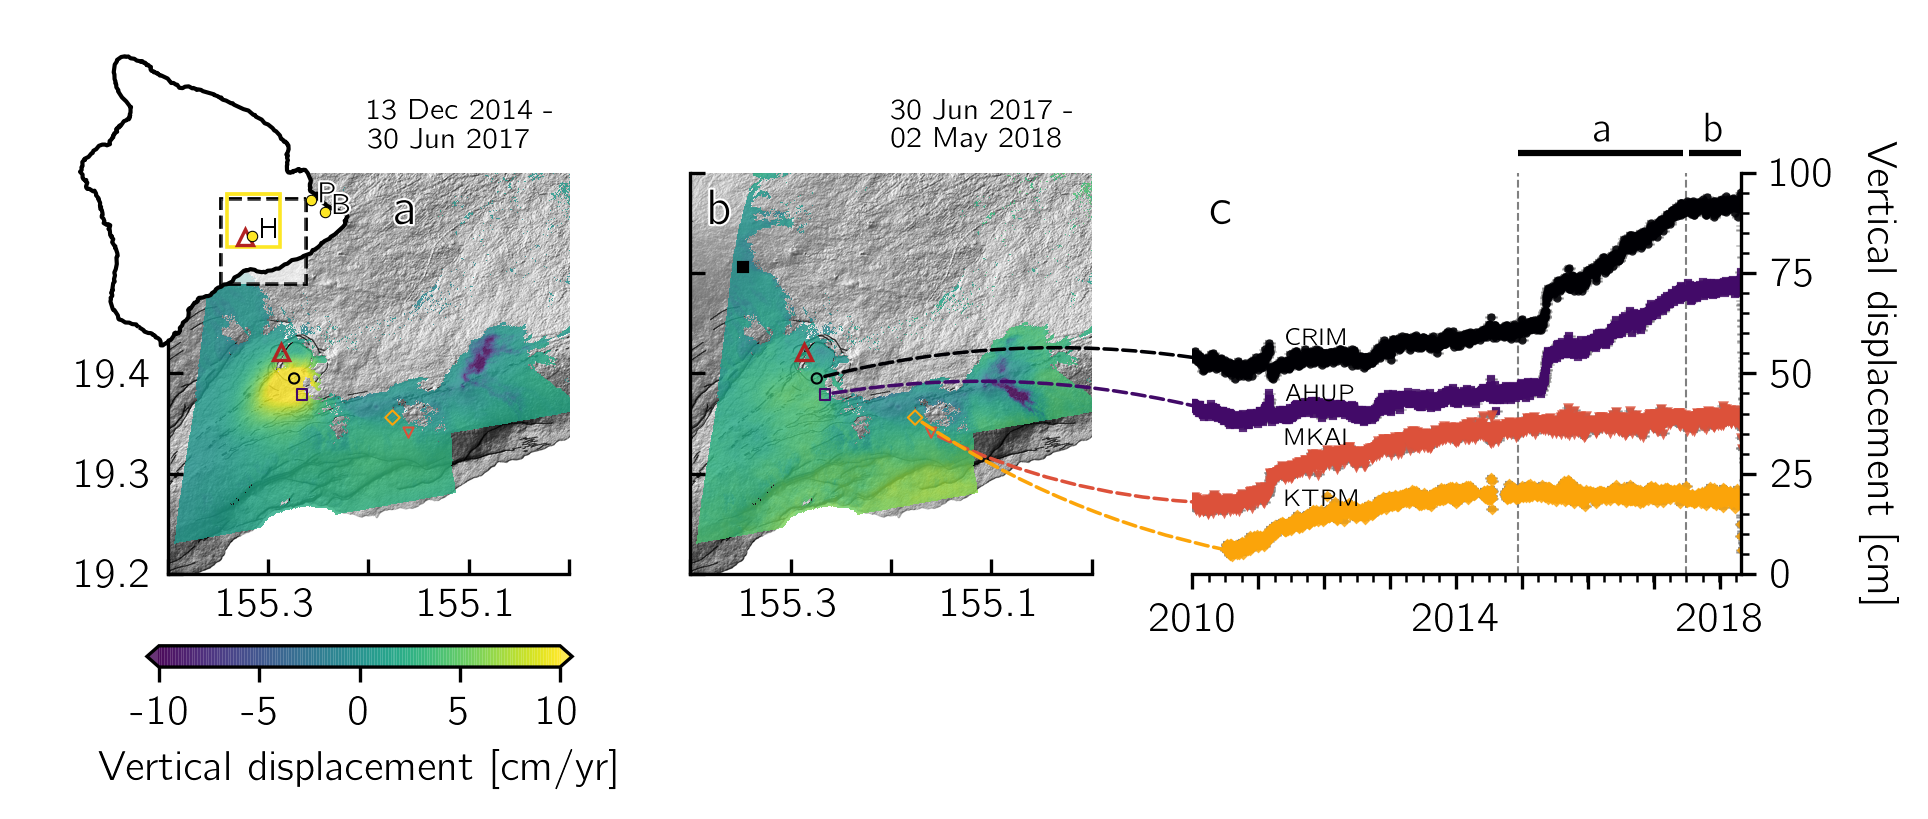

In [58]:
'''
Plots Figure 1 based on imported velocity files via mintpy's view function.
'''

colmap = matplotlib.cm.get_cmap('inferno') #colormap for GPS data

W, N, E, S = (-155.5, 20, -154.800113373004, 18.95) # cardinal coords
buffer = [patheffects.withStroke(linewidth=1, foreground="white")] # path effect for adding outline to text


fig = plt.figure(figsize=mm2inch(180, 45), dpi = 300) ## initiate figure
gs = plt.GridSpec(1, 3, figure=fig, wspace=-0, ## define subplot geometry
                 )
gs_ = plt.GridSpec(1, 3, figure=fig, wspace=-0, ## define subplot geometry
                   left = 0.1 
                 )
plt.rcParams["font.family"] = 'sans-serif'
## Add axes to figure
axs = [fig.add_subplot((gs[0, 0])),
        fig.add_subplot(gs_[0, 1]),
        fig.add_subplot(gs[0, 2]),]

## Import velocity files

vel_files = (["../../../up_2015_2017.h5",
              "../../../up_2018.h5",
             ])
## Set up markers
marker_shapes = ["o", "s", "*", "v", "D"]
marker_colors = [colmap(x) for x in np.arange(0,1.1,0.2)]

########### panel a & b ###########
## Use MintPy.view() to plot velocity data on DEM
start_dates = []
end_dates = []
for i in range(len(vel_files)):
    ax = axs[i]
    cmd =  'view.py {} velocity -u cm/yr '.format(vel_files[i])
    cmd += '--sub-lat {} {} --sub-lon {} {} '.format(S, N, W, E)
    cmd += '-c viridis --nocbar --vlim -10 10 '
    cmd += '--dem {} --dem-nocontour --shade-min -4500 --shade-max 5000 '.format(dem_file)
    cmd += '--noscalebar --notitle --fontsize 12 --ref-size 2'

    d_v, atr, inps = view.prep_slice(cmd)
    ax, inps, im, cbar = view.plot_slice(ax, d_v, atr, inps)
    s_date = '{2} {1} {0}'.format(atr["START_DATE"][0:4],
                                  calendar.month_abbr[int(atr["START_DATE"][4:6])],atr["START_DATE"][6:])
    e_date = '{2} {1} {0}'.format(atr["END_DATE"][0:4],
                                  calendar.month_abbr[int(atr["END_DATE"][4:6])],atr["END_DATE"][6:])
    ax.set_title("{} -\n {}".format(s_date,e_date), fontsize = "x-small", ha="left")#, y=-0.04)
    
    kil_lalo = (lat_volc, lon_volc)
    ax.plot(kil_lalo[1], kil_lalo[0],'^', ms=4, mec='firebrick', mfc='none', mew=0.8)

    faults.plot(ax = ax, marker = ".",markersize=0.25, color = "k",edgecolor = "None", zorder = 1, alpha = 0.5)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:.1f}'.format(x))
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:.1f}'.format(-x))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.xaxis.set_major_formatter(ticks_x)
    ax.tick_params(axis='both', which='major', labelsize="xx-small", direction="in")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    for j,k in enumerate([0,1,3,4]):#stations):
        ax.scatter(stat_lons[k], stat_lats[k], marker = marker_shapes[k], s=6,
                   facecolor = "None", edgecolor = marker_colors[k],linewidth = 0.5,
                   zorder = 11, label=k)
    start_dates.append(datetime(int(atr["START_DATE"][0:4]), int(atr["START_DATE"][4:6]), int(atr["START_DATE"][6:8])))
    end_dates.append(datetime(int(atr["END_DATE"][0:4]), int(atr["END_DATE"][4:6]), int(atr["END_DATE"][6:8])))
############# panel c #############
## Plot vertical GPS data time-series
n = 1
first_date = datetime.strptime("20100101", '%Y%m%d')
for num, frame in enumerate(frame_names):
    if frame!='kosm':# KOSM station included in data file, but not plotted here.
        frame = frame+'_data'
        frame = gps_dict[frame]
        if frame.date[0] <= first_date: 
            first = frame[frame.date == "2010-01-01"].up.values
        else:
            first = frame.up[0]
        axs[2].errorbar(frame.date[::n], frame.up[::n]-first # displacement since 2010
                     +(-.12*num+.54), # manual offset for clarity
                     frame.error[::n], fmt=marker_shapes[num],ms=1,
                 mfc = "None",mec=marker_colors[num],ecolor='grey', capsize=1, elinewidth=3, alpha = 0.85)
axs[2].set_xlim("2010-01-01", "2018-05-02")        
axs[2].set_ylim(0,1)
axs[2].set_ylabel("Vertical displacement [cm]", rotation = 270, labelpad = 15)
axs[2].axvline(x="2014-12-13", linewidth = 0.5, linestyle = "dashed", color = "grey", zorder = 0)
axs[2].axvline(x="2017-06-30", linewidth = 0.5, linestyle = "dashed", color = "grey", zorder = 0)
axs[2].axvline(x="2018-05-03", linewidth = 0.5, linestyle = "solid", color = "k", zorder = 0)
axs[2].yaxis.tick_right()
axs[2].yaxis.set_label_position("right")

ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*100))
axs[2].yaxis.set_major_formatter(ticks_y)
years = mdates.YearLocator()  
axs[2].xaxis.set_major_locator(years)
axs[2].set_xticklabels([str(x) for x in range(2010, 2020,)])
ln = 4  # Keeps every nth label
[l.set_visible(False) for (i,l) in enumerate(axs[2].xaxis.get_ticklabels()) if i % ln != 0]
note_locs =[0.57,0.43,0.3,0.17,0.32] 
for num, frame in enumerate(frame_names):
    if num in [0,1,3,4]:
        axs[2].annotate(frame.upper(), xy=("2011-01-01",note_locs[num]),
                        xycoords='data', xytext=("2011-06-01",note_locs[num]),fontsize = "xx-small")
axs[2].spines["left"].set_visible(False)
axs[2].spines["top"].set_visible(False)
axs[2].hlines(xmin = "2014-12-13", xmax = "2017-06-15", y = 1.05, clip_on=False)
axs[2].hlines(xmin = "2017-07-15", xmax = "2018-05-02", y = 1.05, clip_on=False)

for num, label in enumerate(STRING.ascii_lowercase[0:2]):
    axs[2].annotate(label, xy = ((start_dates[num]+(end_dates[num]-start_dates[num])/2),1),
               xycoords='data',xytext = ((start_dates[num]+(end_dates[num]-start_dates[num])/2),1.15),
                color='k',fontsize = 10, path_effects = buffer,ha='center',
                    va='top', zorder = 1000)

####### colorbar ####
# adds a separate axis for the colorbar
cax = fig.add_axes([0.15, -0.05, 0.2, 0.04])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal',
                    ticks=[-10,-5, 0, 5,10], extend="both", extendfrac=.03)
cbar.set_label('Vertical displacement [cm/yr]')#, fontsize="small")#, labelpad= 15, rotation = 270)
cbar.ax.xaxis.set_label_position('bottom')
cbar.ax.xaxis.set_ticks_position('bottom')
ticks_cb = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x))
cax.xaxis.set_major_formatter(ticks_cb)

###### mapax #####
# adds an axis with an inset map
axs.append(fig.add_axes([0.06,0.55, 0.25, 0.6]))
m = Basemap(llcrnrlon=-156.3,
            llcrnrlat=18.9,
            urcrnrlon=-154.5,
            urcrnrlat=20.4,
            projection='cyl',
            resolution = 'h',
            area_thresh=110,
            ax=axs[3])
m.drawcoastlines(linewidth = 1, color = 'k')
m.fillcontinents(color='w')

## Adds polygons tooo highlight region of interest and satellite data footprint.
x1,y1 = (j_volc+0.25,i_volc)
x2,y2 = (j_volc+0.25,i_volc+0.25)
x3,y3 = (j_volc,i_volc+0.25)
x4,y4 = (j_volc,i_volc)
poly = Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)],
               facecolor='None',hatch = '', edgecolor=vir_y, linestyle = "solid",linewidth=.85,
                zorder = 10)
axs[3].add_patch(poly)
poly2 = Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)],
                facecolor='w',hatch = '', edgecolor=vir_y, linestyle = "solid",linewidth=.85,
                zorder = 1, alpha = 0.7)
axs[3].add_patch(poly2)

W, N, E, S = (-155.4, 19.6, -155, 19.2) ## cardinal coords
poly3 = Polygon([(E,N), (E,S), (W,S), (W,N)],
                facecolor='None', edgecolor = 'k', linestyle ="dashed", linewidth =.85)
axs[3].add_patch(poly3)
poly4 = Polygon([(E,N), (E,S), (W,S), (W,N)],
                facecolor='w', edgecolor = 'k', linestyle ="dashed", linewidth =.85, zorder = 1, alpha = 0.7)
axs[3].add_patch(poly4)

axs[3].axis('off')
# faults.plot(ax = axs[3], marker = ".",markersize=0.25, color = "grey",edgecolor = "None", zorder = 10, alpha = 0.5)


## add relevant points to map, incl. location of volcano, location of rain gauges.
axs[3].plot(kil_lalo[1], kil_lalo[0],'^', ms=4, mec='firebrick', mfc='none', mew=0.8, zorder = 11)
axs[3].annotate(r"H", xy = (-155.2562, 19.4297), #HVNP rain gauge
             xytext=(-155.2562+0.03, 19.4297-0.01),
             fontsize = "x-small",
            path_effects=buffer)
axs[3].annotate(r"P", xy = (-154.976, 19.596), #Paradise Park rain gauge
             xytext=(-154.976+0.03, 19.596-0.01),
             fontsize = "x-small",
            path_effects=buffer) #19.596, -154.976
axs[3].annotate(r"B", xy = (-154.91194,19.54111), #Beaches rain gauge
             xytext=(-154.91194+0.03, 19.54111-0.01),
             fontsize = "x-small",
            path_effects=buffer, zorder = 20)

axs[3].scatter(-155.2562, 19.4297, marker = '.',
               s=25, facecolor = vir_y, edgecolor = "k",linewidth = 0.25, zorder = 12)
axs[3].scatter(-154.976, 19.596, marker = '.',
               s=25, facecolor = vir_y, edgecolor = "k",linewidth = 0.25, zorder = 12)
axs[3].scatter(-154.91194, 19.54111, marker = '.',
               s=25, facecolor = vir_y, edgecolor = "k",linewidth = 0.25, zorder = 12)


##### figure additions #####
## Adds connecting lines between figure panels.
axs[2].set_zorder(-1)    
arc_rad =[-0.1,-0.1,-0.1,0.1,0.1]
for num, frame in enumerate(frame_names):
    offset = -.12*num+.54
    if num!=2:
        frame = frame+'_data'
        frame = gps_dict[frame]
        if frame.date[0] <= first_date: 
            first = frame[frame.date == "2010-01-01"].up.values
            xy_b = (frame[frame.date == "2010-01-01"].date.values,
                    frame[frame.date == "2010-01-01"].up.values-first+offset)
        else:
            xy_b = (frame.date[0], offset)#
        con = ConnectionPatch(xyA=(stat_lons[num],stat_lats[num]), xyB=xy_b, coordsA="data", coordsB="data",
                          axesA=axs[1], axesB=axs[2], color=marker_colors[num],
                          connectionstyle = "arc3,rad={}".format(arc_rad[num]),
                          linestyle="--",
                          shrinkA=2, shrinkB=0,linewidth = 0.85,
                           fc=marker_colors[num], zorder = 99)
        axs[1].add_artist(con)
        
## Denotes panels with a, b, c 
text_coord = [54,4,4] 
for num in range(0,3):
    axs[num].annotate(STRING.ascii_lowercase[num], (0, 1),xytext=(text_coord[num], -4),
                      xycoords='axes fraction',textcoords='offset points',
    color='k',fontsize = 12, path_effects = buffer,ha='left', va='top', zorder = 1000)

## Ensure only the ticks and ticklabels we need are shown.
axs[2].minorticks_on()

[l.set_visible(False) for (i,l) in enumerate(axs[0].yaxis.get_ticklabels()) if not i in range(3)]
[l.set_visible(False) for (i,l) in enumerate(axs[1].yaxis.get_ticklabels())]

for i in range(2):
    axs[i].set_ylim(19.2, 19.6)
    axs[i].set_xlim(-155.4, -155)
    [l.set_visible(False) for (m,l) in enumerate(axs[i].xaxis.get_ticklabels()) if not m % 2 == 1]
    for label in (axs[i].get_xticklabels() + axs[i].get_yticklabels()):
        label.set_fontproperties(matplotlib.font_manager.FontProperties(size=10))

# plt.savefig(filepath+"/figures/kil_fig_1.png", bbox_inches="tight") ## save as PNG format
# plt.savefig(filepath+"/figures/kil_fig_1.pdf", bbox_inches="tight") ## save as vector format

plt.show()

**Figure 1 |** Pre-eruption ground deformation of study site. a Vertical deformation map derived from Sentinel-1 InSAR data (ascending track 124 and descending track 87) between Dec 2014 and Jun 2017. [inset] Location map of Kīlauea Volcano (open triangle), and the HVNP rain gauge (H) within the Eastern Rift Zone (fault lines shown in black). Solid line yellow box indicates the 0.25 × 0.25 ° TRMM/GPM footprint used in this study. Paradise Park Well (P) and Hawaiian Beaches rain gauge (B) are also highlighted (see Supplementary Information 1). Dashed box indicates region shown in a and b. In a and b, filled square is reference point, Open symbols represent GPS station locations. b Vertical deformation between Jun 2017 and May 2018. c Vertical GPS displacement of Kīlauea flank from 2010. Station IDs are shown on the panel; symbols correspond to locations in a and b. Dashed vertical lines highlight significant change-of-slope in station data proximal to the summit (CRIM, AHUP). Datasets have been offset from x-axis for clarity.

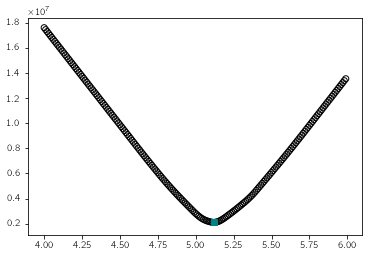

Scale factor : 5.12


In [62]:
'''
Read in available rain gauge data near Kilauea
# ''' 
kilauea_gauge = pd.read_csv(filepath+"/gauge_data/1679027.csv")
long_term_gauge = pd.read_csv(filepath+"/gauge_data/1738950.csv")

lt_datetimes = []
lt_dates =[]

## Create series of datetimes
for j in long_term_gauge.DATE:
    lt_datetimes.append(dt.datetime.strptime(j, "%Y-%m-%d"))
for j in lt_datetimes:
    lt_dates.append(dt.date(j.year,j.month,j.day))
long_term_gauge["dates"] = lt_dates


ki_datetimes = []
ki_dates =[]

for j in kilauea_gauge.DATE:
    ki_datetimes.append(dt.datetime.strptime(j, "%Y-%m-%d"))
for j in ki_datetimes:
    ki_dates.append(dt.date(j.year,j.month,j.day))
kilauea_gauge["dates"] = ki_dates

hvnp = kilauea_gauge[kilauea_gauge.NAME == 'HAWAII VOL. NATIONAL PARK HQ. 54, HI US'].reset_index()
hvnp["cum"] = hvnp.PRCP.cumsum()

'''
Append precipitation data from TRMM/ GPM data for Kilauea geolocation 
(i.e. lat/lon defined by i_volc and j_volc.)
'''
ki_rainfall = []
for j,k in enumerate(precipitation):
    ki_rainfall.append(precipitation[j][list(latitude).index(i_volc)][list(longitude).index(j_volc)])

ki_rain = pd.DataFrame({"date": file_dates, "rain": ki_rainfall})
ki_rain["cum"] = ki_rain.rain.cumsum()

lt_ki_rain = pd.DataFrame({"date": long_term_gauge.dates, "rain": long_term_gauge.PRCP})
lt_ki_rain.rain = lt_ki_rain.rain*25.4  # inches to mm
lt_ki_rain["cum"] = lt_ki_rain.rain.cumsum()

'''
Determine the scale factor that minimises the residuals between the gauge and satellite datasets
'''
cum1=hvnp.cum

cum2=ki_rain.cum[0:len(hvnp.cum)]
resids = []
coeffs = np.arange(4,6,0.01)
for i in coeffs:
    cum_diff = []
    for j, k in enumerate(cum1):
        cum_diff.append(abs(k-(cum2[j]*i)))
    resids.append(np.nansum(cum_diff))
plt.scatter(coeffs,resids, marker = "o", edgecolor ="k", color = "None")  
scale_factor = coeffs[np.argmin(resids)]
plt.scatter(scale_factor, resids[np.argmin(resids)], marker = "s", color = "teal")
plt.show()

print("Scale factor : {:.2f}".format(scale_factor))

In [63]:
'''
Rainfall is calibrated according to gauge data
'''
rainfall = [x * scale_factor for x in ki_rainfall]
rainfall_m = [x / 1e3 for x in rainfall] # rainfall in meters

rain_dates = pd.DataFrame( # dataframe containing "pentad" data (five-day running mean), for later use
    {'date':file_dates[:],
     'rainfall': rainfall
    })
j = 5
pentads = rain_dates.rainfall.rolling(j).mean()
pentads.fillna(0, inplace=True)

In [64]:
'''
Calculates cumulative rainfall amounts for rolling windows of 30, 90, 120, and 180 days.
'''

rainfalldf = pd.DataFrame({"date": file_dates, "rain": rainfall})

rainfalldf["roll30"] = rainfalldf.rain.rolling(30).sum()
rainfalldf["roll90"] = rainfalldf.rain.rolling(90).sum()
rainfalldf["roll120"] = rainfalldf.rain.rolling(120).sum()
rainfalldf["roll180"] = rainfalldf.rain.rolling(180).sum()

rainfalldf["log30"] = np.log(rainfalldf.roll30)
rainfalldf["log90"] = np.log(rainfalldf.roll90)
rainfalldf["log180"] = np.log(rainfalldf.roll180)

rainfalldf["cum"] = rainfalldf.rain.cumsum() 

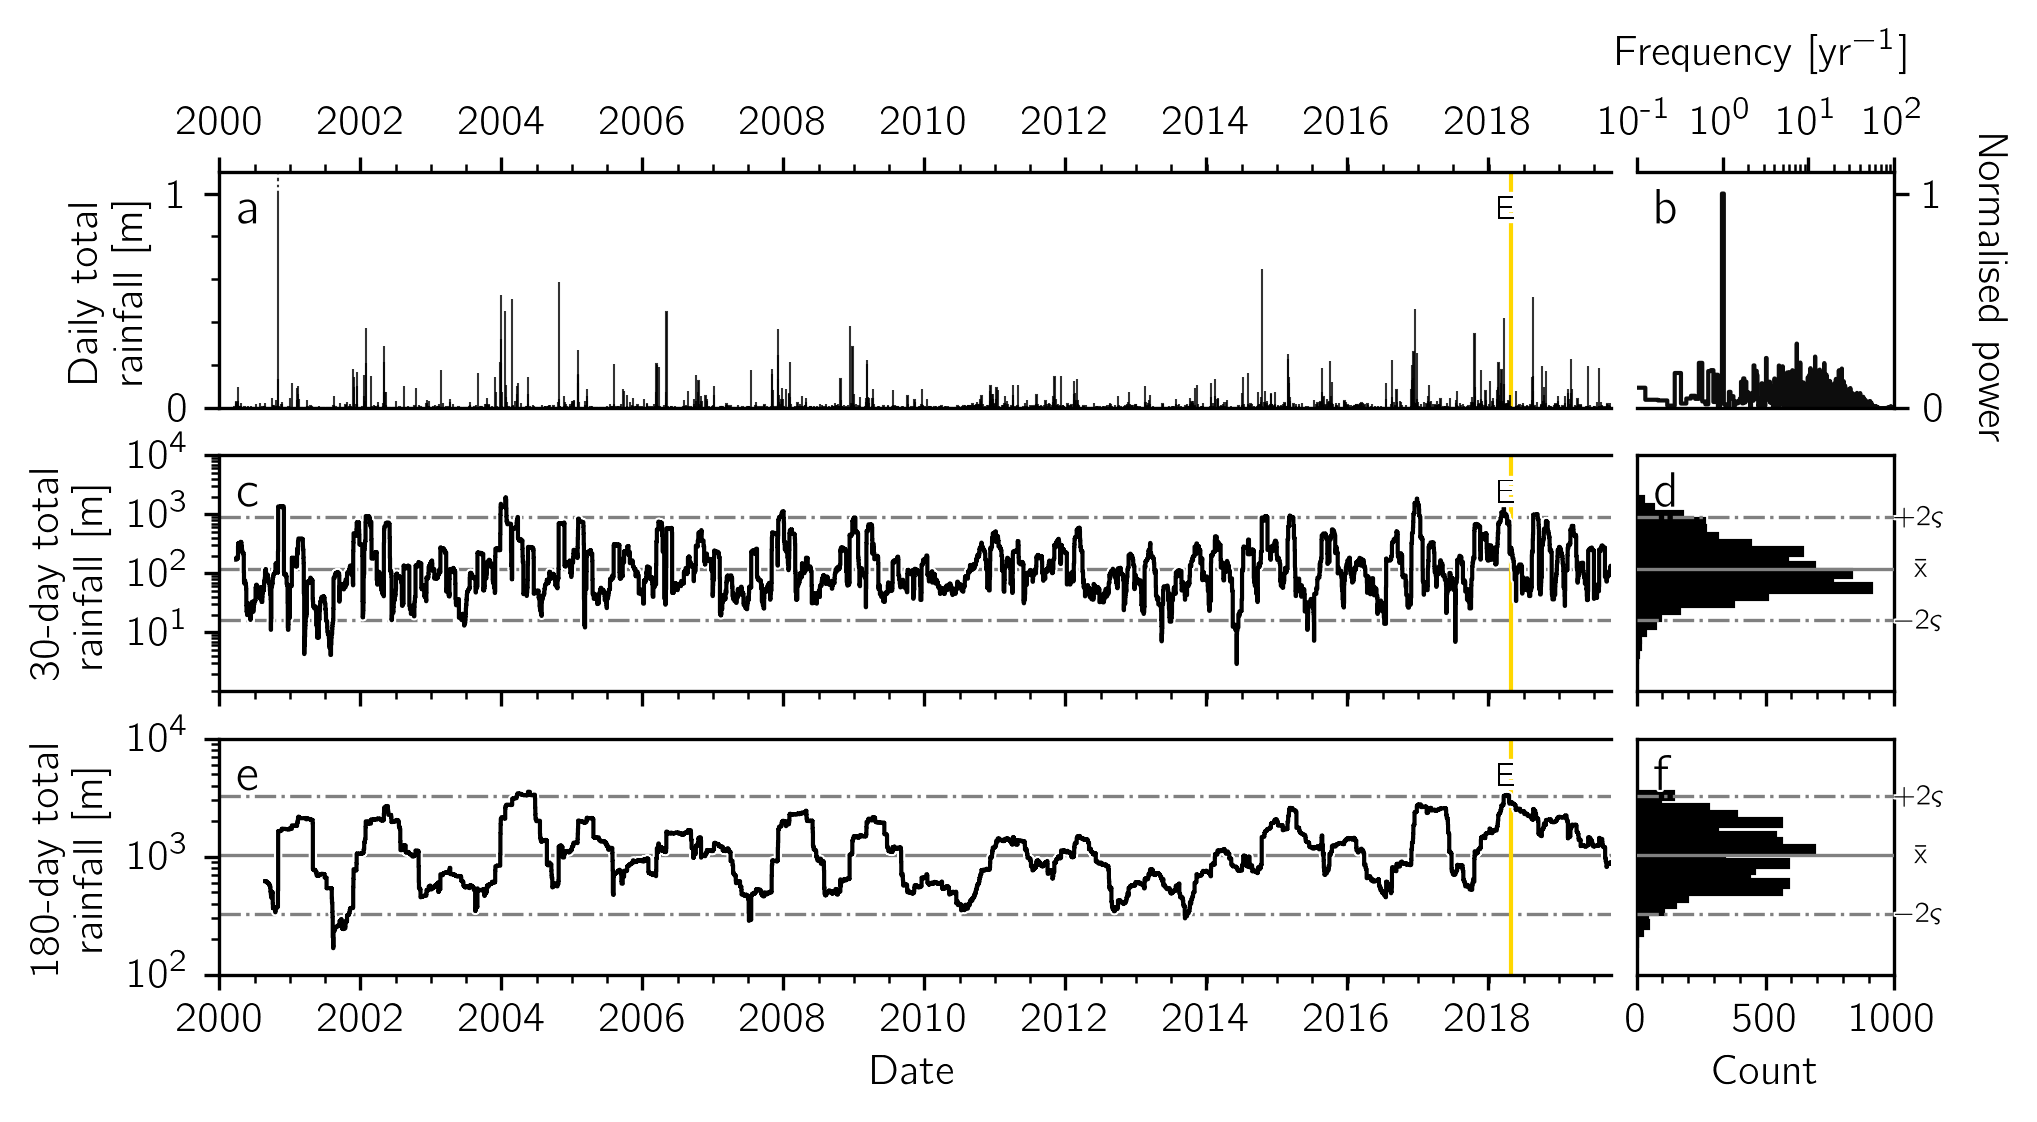

In [65]:
'''
Plots Figure 2 based on processed rainfall data.
'''
fig = plt.figure(figsize=mm2inch(183, 90), dpi = 300) ## initiate figure 
gs = plt.GridSpec(3, 6, figure=fig, wspace=0.1) ## define axes 
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) ## set up logarithmic axis options
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(np.arange(0.1,1,0.1)),numticks=12)

axs = [fig.add_subplot((gs[0, :-1])), ## add axes to figure
        fig.add_subplot(gs[0, -1]),
        fig.add_subplot(gs[1, :-1]),
               fig.add_subplot(gs[1,-1]),
      fig.add_subplot(gs[2,:-1]),
              fig.add_subplot(gs[2,-1]),]

ys = np.arange(-2000,2100,0.5)
xax1 = ["2018-01-01" for y in ys]
xax2 = ["2018-03-31" for y in ys]

################ panel a ###############
## bar chart of daily rainfall 
axs[0].bar(file_dates,rainfall_m,
           color="k",
           linewidth = .5,
           edgecolor = "k",alpha =0.8)
axs[0].set_xlim(min(file_dates), max(file_dates))
axs[0].set_ylim(0, 1.1)#max(rainfall_m))
axs[0].set_ylabel('Daily total\nrainfall [m]')
axs[0].set_yticks([0,1])
axs[0].spines['right'].set_visible(False)
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x))
axs[0].yaxis.set_major_formatter(ticks_y)
axs[0].xaxis.tick_top()
axs[0].xaxis.set_label_position('top') 
axs[0].set_xlim("2000-01-01", "2019-10-01")
axs[0].minorticks_on()
################ panel a ###############

############### panel b ###############
## Processes rainfall time-series and plots as a power spectrum.
A = np.fft.fft(pentads) ## Fast Fourier transform
B = np.abs(A)**2

n = pentads.size
freq = np.fft.fftfreq(n, d= 1/365.25) ## Fast Fourier transform
k = freq > 0

axs[1].set_xlim(0.1,100)
axs[1].set_ylim(0,1.1)
axs[1].step(freq[k],B[k]/max(B[k]),
            color = 'k',
            linestyle = 'solid',
            linewidth =1, alpha = 0.95, where = 'mid') # Normalised power versus frequency
plt.minorticks_on()

axs[1].set_ylabel("Normalised power", rotation = 270, labelpad = 15)
axs[1].set_xlabel(r'Frequency [yr$^{-1}$]', labelpad = 10)

ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x))
axs[1].yaxis.set_major_formatter(ticks_y)
axs[1].xaxis.set_major_formatter(ticks_y)

axs[1].xaxis.tick_top()
axs[1].xaxis.set_label_position('top') 
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position('right') 
axs[1].set_xscale("log")
axs[1].xaxis.set_major_formatter(LogFormatterTexTextMode())
axs[1].xaxis.set_major_locator(locmaj)
axs[1].xaxis.set_minor_locator(locmin)
axs[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
axs[1].set_xticks([0.1,1,10,100])

axs[1].spines["left"].set_visible(False)
################ panel b ###############

################ panel c ###############
## Plots rolling average of rainfall data (average over 30 days)
log_data_30 = [np.log(x) for x in rainfalldf.roll30]
axs[2].step(rainfalldf.date, rainfalldf.roll30, color = 'w', lw=2)
axs[2].step(rainfalldf.date, rainfalldf.roll30, color = 'k', lw=1)
axs[2].axhline(y= np.exp(np.nanmean(log_data_30)), color = 'grey', lw = .8, zorder = 0)
axs[2].axhline(np.exp(np.nanmean(log_data_30)+(2*np.nanstd(log_data_30))),
               color = 'grey', lw = .8 , zorder = 0, ls = '-.')
axs[2].axhline(np.exp(np.nanmean(log_data_30)-(2*np.nanstd(log_data_30))),
               color = 'grey', lw = .8 , zorder = 0, ls = '-.')
axs[2].set_ylabel("30-day total\nrainfall [m]")
axs[2].set_xlim("2000-01-01", "2019-10-01")
axs[2].set_yticks([0,1000,2000])
axs[2].set_yscale("log")
axs[2].axvline(x='2018-05-03', lw =1, color = 'gold', zorder =1)
axs[2].set_ylim(1e0,1e4)


axs[2].set_yticklabels([1e0,1e1,1e2,1e3,1e4])
axs[2].minorticks_on()
axs[2].yaxis.set_major_formatter(LogFormatterTexTextMode())
axs[2].yaxis.set_major_locator(locmaj)
axs[2].yaxis.set_minor_locator(locmin)
axs[2].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
################ panel c ###############

################ panel d ###############
## plots PDF of logged rainfall data averaged over 30 days
MIN, MAX = np.nanmin(rainfalldf.roll30), np.nanmax(rainfalldf.roll30)
axs[3].hist(rainfalldf.roll30, bins = 10 ** np.linspace(np.log10(MIN), np.log10(MAX), 24), orientation = 'horizontal',
        color = 'k', density = False, ec = 'k')
axs[3].set_yscale("log")

axs[3].axhline(np.exp(np.nanmean(log_data_30)), color = 'grey', lw = .8, zorder = 10)
axs[3].axhline(np.exp(np.nanmean(log_data_30)+(2*np.nanstd(log_data_30))), color = 'grey', lw = .8 , zorder = 10, ls = '-.')
axs[3].axhline(np.exp(np.nanmean(log_data_30)-(2*np.nanstd(log_data_30))), color = 'grey', lw = .8 , zorder = 10, ls = '-.')
axs[3].set_yticks([])
axs[3].set_ylim(1e0,1e4)
axs[3].annotate(r"\={x}", xy=(750,
                      np.exp(np.nanmean(log_data_30))),
             xycoords = 'data', fontsize = 'x-small', 
             path_effects = buffer,
            xytext=(20, -2),textcoords='offset points',)
axs[3].annotate(r"$+2\varsigma$", xy=(750,
                      np.exp(np.nanmean(log_data_30)+(2*np.nanstd(log_data_30)))),
             xycoords = 'data', fontsize = 'x-small', 
             path_effects = buffer,
            xytext=(15, -2),textcoords='offset points',)
axs[3].annotate(r"$-2\varsigma$", xy=(750,
                      np.exp(np.nanmean(log_data_30)-(2*np.nanstd(log_data_30)))),
             xycoords = 'data', fontsize = 'x-small', 
             path_effects = buffer,
            xytext=(15, -2),textcoords='offset points',)
axs[3].set_xlim(0,1000)

################ panel d ###############

################ panel e ###############
## Plots rolling average of rainfall data (average over 180 days)
log_data_180 = [np.log(x) for x in rainfalldf.roll180]
axs[4].step(rainfalldf.date, rainfalldf.roll180, color = 'w', lw=2)
axs[4].step(rainfalldf.date, rainfalldf.roll180, color = 'k', lw=1)
axs[4].axhline(y= np.exp(np.nanmean(log_data_180)), color = 'grey', lw = .8, zorder = 0)
axs[4].axhline(np.exp(np.nanmean(log_data_180)+(2*np.nanstd(log_data_180))),
               color = 'grey', lw = .8 , zorder = 0, ls = '-.')
axs[4].axhline(np.exp(np.nanmean(log_data_180)-(2*np.nanstd(log_data_180))),
               color = 'grey', lw = .8 , zorder = 0, ls = '-.')
axs[4].set_ylabel("180-day total\nrainfall [m]")
axs[4].set_xlim("2000-01-01", "2019-10-01")
axs[4].set_yticks([0,1000,2000])
axs[4].set_yscale("log")
axs[4].axvline(x='2018-05-03', lw =1, color = 'gold', zorder =1)
axs[4].set_ylim(1e2,1e4)
axs[4].minorticks_on()

axs[5].set_ylim(1e2,1e4)
axs[4].yaxis.set_major_formatter(LogFormatterTexTextMode())
axs[4].yaxis.set_major_locator(locmaj)
axs[4].yaxis.set_minor_locator(locmin)
axs[4].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

################ panel e ###############

################ panel f ###############
## plots PDF of logged rainfall data averaged over 30 days
MIN, MAX = np.nanmin(rainfalldf.roll180), np.nanmax(rainfalldf.roll180)
axs[5].hist(rainfalldf.roll180, bins = 10 ** np.linspace(np.log10(MIN), np.log10(MAX), 24), orientation = 'horizontal',
        color = 'k', density = False, ec = 'k')
axs[5].set_yscale("log")

axs[5].axhline(np.exp(np.nanmean(log_data_180)), color = 'grey', lw = .8, zorder = 10)
axs[5].axhline(np.exp(np.nanmean(log_data_180)+(2*np.nanstd(log_data_180))),
               color = 'grey', lw = .8 , zorder = 10, ls = '-.')
axs[5].axhline(np.exp(np.nanmean(log_data_180)-(2*np.nanstd(log_data_180))),
               color = 'grey', lw = .8 , zorder = 10, ls = '-.')
axs[5].set_yticks([])
axs[5].annotate(r"\={x}", xy=(750,
                      np.exp(np.nanmean(log_data_180))),
             xycoords = 'data', fontsize = 'x-small', 
             path_effects = buffer,
            xytext=(20, -2),textcoords='offset points',)
axs[5].annotate(r"$+2\varsigma$", xy=(750,
                      np.exp(np.nanmean(log_data_180)+(2*np.nanstd(log_data_180)))),
             xycoords = 'data', fontsize = 'x-small', 
             path_effects = buffer,
            xytext=(15, -2),textcoords='offset points',)
axs[5].annotate(r"$-2\varsigma$", xy=(750,
                      np.exp(np.nanmean(log_data_180)-(2*np.nanstd(log_data_180)))),
             xycoords = 'data', fontsize = 'x-small', 
             path_effects = buffer,
            xytext=(15, -2),textcoords='offset points',)
axs[4].set_xlabel('Date')
axs[5].set_xlabel('Count')
axs[5].set_xlim(0,1000)

################ panel f ###############

## Add axis labels and clean up plot
for num, label in enumerate(STRING.ascii_lowercase[0:6]):
    axs[num].annotate(label, (0, 1),xytext=(4, -4),
                      xycoords='axes fraction',textcoords='offset points',
    color='k',fontsize = 12, path_effects = buffer,ha='left', va='top', zorder = 1000)

axs[2].set_xticklabels([])
axs[3].set_xticklabels([])

axs[3].minorticks_on()
for num in [1.08,1.05,1.02]:
    axs[0].hlines(xmin="2000-03-15", xmax="2002-01-01",y=num, clip_on=True, linewidth = 0.85, color = "w")
axs[2].spines["right"].set_visible(False)
axs[4].spines["right"].set_visible(False)

## Add figure annotations
axs[0].annotate("E", fontsize = 8,
             xy = (.925,.8),xycoords="axes fraction",
             path_effects = [patheffects.withStroke(linewidth=2, foreground="w")], ha = 'center', zorder = 11)
axs[0].axvline(x='2018-05-03', lw =1, color = 'gold', zorder =0)
axs[2].annotate("E", fontsize = 8,
             xy = (.925,.8),xycoords="axes fraction",
             path_effects = [patheffects.withStroke(linewidth=2, foreground="w")], ha = 'center', zorder = 11)
axs[4].annotate("E", fontsize = 8,
             xy = (.925,.8),xycoords="axes fraction",
             path_effects = [patheffects.withStroke(linewidth=2, foreground="w")], ha = 'center', zorder = 11)
plt.tight_layout()
plt.savefig(filepath+"/figures/kil_fig_2.png", bbox_inches="tight") ## save figure as image format
plt.savefig(filepath+"/figures/kil_fig_2.pdf", bbox_inches="tight") ## save figure as vector format

plt.show()

**Figure 2 |** Rainfall over Kīlauea. a Calibrated daily rainfall amount over Kīlauea from Mar 2000 and July 2019 (TRMM/GPM data calibrated with gauge data; see Fig. 1a [inset] and Methods). Vertical bar shows date of flank eruption (E). b Power spectrum of Fourier-transformed rainfall time-series (a) shown in the (normalised) power–frequency domain. c Rolling 30-day cumulative rainfall since Mar 2000 at Kīlauea. Horizontal dashed lines delineate 2 standard deviations either side of the mean (+/- 2 sigma). d Histogram of data in c on log-linear axes. e Rolling 180-day cumulative rainfall. f Histogram of data in e on log-linear axes. 

In [66]:
'''
Returns diffusivity value "alpha" based on input permeability "k", compressibility "beta", and porosity "phi" values.
Returns defaults if arguments aren't passed.
'''
def alpha(k=1e-15,beta=1e-10, phi=0.2):
    mu = 8.9e-4
    alpha = k/(beta*mu*phi)
    return alpha

In [67]:
'''
Calculates three different average permeabilities for the edifice domain,
based on the width (wi) and permeability (ki)  of different components 
based on current hydrogeological understanding of Kilauea. 
These are the arithmetic mean permeability (kx), the harmonic mean permeability (kz), 
and the geometric mean permeability (kg).

'''
wi = [500,700, 4800]
ki = [1e-10,1e-14,1e-16]
kz = np.sum(wi)/np.sum(np.divide(wi,ki))
kx = np.sum(np.multiply(wi,ki))/sum(wi)
kg = np.exp(np.sum(np.multiply(wi,np.log(ki)))/np.sum(wi))
print('kz = {:.2e}; kx = {:.2e}; kg = {:.2e}'.format(kz, kx, kg))

kz = 1.25e-16; kx = 8.33e-12; kg = 5.41e-16


In [68]:
''' 
We consider a case in which the precipitation rate distribution
changes the boundary condition for pore-water pressures at the ground surface (z = 0) 
such that this condition can be specified as P(t,z=0) = sR(t)
'''
pz0 = [] ## pressure perturbation at the surface (i.e. depth z = 0)
rho = 997. ## water density
g = 9.80665 ## gravity
for j,k in enumerate(rainfall_m):
    pz0.append(rainfall_m[j]*rho*g)
    # pressure defined as a pseudovector, assuming the height of rainfall (in m),
    # the density of water, and acceleration due to gravity.

In [71]:
'''
Model runs may take several minutes to half an hour depending on their size and complexity. 
Model products are provided here for all figures shown in the paper, and can be loaded in lieu of running the models.
Model runs are complete up until mid-July 2019. Simply uncomment as appropriate. 
''' 

# u_combined =  np.genfromtxt(filepath+"/model_products/u_combined.csv")     # (Preferred) 2-domain model (satellite data)
# u_comb_lt =  np.genfromtxt(filepath+"/model_products/u_comb_lt.csv")       # (Preferred) 2-domain model (long-term gauge data)
# u_3_stage =  np.genfromtxt(filepath+"/model_products/u_3_stage.csv")       # 3-domain model (satellite data)
u_3_stage_lt =  np.genfromtxt(filepath+"/model_products/u_3_stage_lt.csv") # 3-domain model (long-term gauge data)
# u_kx =  np.genfromtxt(filepath+"/model_products/u_kx.csv")                 # Homogeneous model based on arithmetic mean permeability (satellite data)
u_kx_lt =  np.genfromtxt(filepath+"/model_products/u_kx_lt.csv")           # Homogeneous model based on arithmetic mean permeability (long-term gauge data)
# u_kg =  np.genfromtxt(filepath+"/model_products/u_kg.csv")                 # Homogeneous model based on geometric mean permeability (satellite data)
u_kg_lt =  np.genfromtxt(filepath+"/model_products/u_kg_lt.csv")           # Homogeneous model based on geometric mean permeability (long-term gauge data)
# u_comb_para =  np.genfromtxt(filepath+"/model_products/u_comb_para.csv")    # 2-domain model using data from Paradise Park
# u_parapark =  np.genfromtxt(filepath+"/model_products/u_parapark.csv")     # 2-domain model using data from Paradise Park

'''
If the models are not being run, the for loop below will also have to be uncommented accordingly to plot Figure 3.
'''
# y = np.arange(0,1e4+dy,dy) 
# #max_u_comb = []
# #max_u_3_stage = []
# #max_u_kg = []
# #max_kx = []
# for j,k in enumerate(y):
# #    max_u_comb.append(max(u_combined[j]))
# #    max_u_3_stage.append(max(u_3_stage[j]))
# #    max_u_kx.append(max(u_kx[j]))
# #    max_u_kg.append(max(u_kg[j]))


'\nIf the models are noot being run, the for loop below will also have to be uncommented accordingly to plot Figure 3.\n'

In [72]:
'''
Diffusion model: second-order implicit in time (Crank-Nicolson method)
'''
def diffusion_Crank_Nicolson(dy,ny,del_t,nt,D,p):
    pout = [] # list for storing p arrays at certain time steps
    p0 = p[0] # boundary condition on left side
    p1 = 0 # boundary condition on right side
    s = D*del_t/dy**2  # diffusion number
    # create coefficient matrix:
    A = diags([-0.5*s, 1+s, -0.5*s], [-1, 0, 1], 
          shape=(ny-2, ny-2)).toarray() 
    B1 = diags([0.5*s, 1-s, 0.5*s],[-1, 0, 1], shape=(ny-2, ny-2)).toarray()

    for n in range(1,nt): # time is going from second time step to last
        pn = p
        B = np.dot(pn[1:-1],B1) 
        B[0] = B[0]+0.5*s*(p0+p0)
        B[-1] = B[-1]+0.5*s*(p1+p1)
        p[1:-1] = np.linalg.solve(A,B)
        p[-2] = p[-1]
        if n==nt-1:
            pout.append(p.copy()) # write copy of p
            
    return pout,s

'''
Diffusion model parameters
'''
def parameters(top_depth, k, phi, iterations):
    diffusivity = alpha(k=k, phi=phi)
    y_max = 10000-top_depth # in m
    y = np.arange(0,y_max+dy,dy) 
    ny = len(y)
    nt = int(24*60*60/del_t)
    num_it = iterations
    u = np.empty((num_it, ny))  
    return ny, nt, diffusivity, y_max, y, u , num_it

Layer 1
01% |  02% |  03% |  04% |  05% |  06% |  07% |  08% |  09% |  10% |  11% |  12% |  13% |  14% |  15% |  16% |  17% |  18% |  19% |  20% |  21% |  22% |  23% |  24% |  25% |  26% |  27% |  28% |  29% |  30% |  31% |  32% |  33% |  34% |  35% |  36% |  37% |  38% |  39% |  40% |  41% |  42% |  43% |  44% |  45% |  46% |  47% |  48% |  49% |  50% |  51% |  52% |  53% |  54% |  55% |  56% |  57% |  58% |  59% |  60% |  61% |  62% |  63% |  64% |  65% |  66% |  67% |  68% |  69% |  70% |  71% |  72% |  73% |  74% |  75% |  76% |  77% |  78% |  79% |  80% |  81% |  82% |  83% |  84% |  85% |  86% |  87% |  88% |  89% |  90% |  91% |  92% |  93% |  94% |  95% |  96% |  97% |  98% |  99% |  100% |  
Layer 2
01% |  02% |  03% |  04% |  05% |  06% |  07% |  08% |  09% |  10% |  11% |  12% |  13% |  14% |  15% |  16% |  17% |  18% |  19% |  20% |  21% |  22% |  23% |  24% |  25% |  26% |  27% |  28% |  29% |  30% |  31% |  32% |  33% |  34% |  35% |  36% |  37% |  38% |  39% |  40% |  41

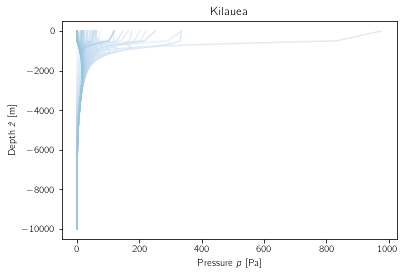

In [73]:
'''
Model parameters and implementation for 2-domain half-space (permeable layer overlying less permeable layer)
'''
del_t = 1000 # grid size for time (s)  
dy = 100 # grid size for space (m)
u_combined = np.zeros((101,len(file_dates)))

######### domain 1 [shallow, permeable]  #########
ny, nt, diffusivity, y_max, y, u, num_it  = parameters(top_depth=0, k=1e-12, phi=0.3, iterations = len(pz0))
p = np.zeros((ny,))
m= -1
print("Layer 1")
for num in range(num_it):
    if num % int(np.ceil(num_it/100)) == 0:
        m+=1
        print('{:02d}% | '.format(np.arange(1,101)[m]), sep=' ', end=' ', flush=True)
    p[0] = pz0[num]
    pout, s = diffusion_Crank_Nicolson(dy,ny,del_t,nt,diffusivity,p)
    u[num] = pout[0]
u_combined[0:6] = u.T[0:6]
p_new = u.T[5]

######### domain 2 [deeper, less permeable]  #########
ny, nt, diffusivity, y_max, y, u, num_it  = parameters(top_depth=500, k=6e-15, phi=0.2, iterations = len(pz0))
p = np.zeros((ny,))
m= -1
print("\nLayer 2")
for num in range(num_it):
    if num % int(np.ceil(num_it/100)) == 0:
        m+=1
        print('{:02d}% | '.format(np.arange(1,101)[m]), sep=' ', end=' ', flush=True)
    p[0] = p_new[num]
    pout, s = diffusion_Crank_Nicolson(dy,ny,del_t,nt,diffusivity,p)
    u[num] = pout[0]
u_combined[5::] = u.T

y = np.arange(0,1e4+dy,dy) 
max_u_comb = []
for j,k in enumerate(y):
    max_u_comb.append(max(u_combined[j]))
 
for num in range(len(y)):
    plt.plot(u_combined[:,num],-y, color = plt.cm.Blues(num), alpha = 0.85)
plt.ylabel("Depth $\hat{z}$ [m]")
plt.xlabel("Pressure $p$ [Pa]")
plt.title("{}".format(name_volc))
plt.show()      


Layer 1
01% |  02% |  03% |  04% |  05% |  06% |  07% |  08% |  09% |  10% |  11% |  12% |  13% |  14% |  15% |  16% |  17% |  18% |  19% |  20% |  21% |  22% |  23% |  24% |  25% |  26% |  27% |  28% |  29% |  30% |  31% |  32% |  33% |  34% |  35% |  36% |  37% |  38% |  39% |  40% |  41% |  42% |  43% |  44% |  45% |  46% |  47% |  48% |  49% |  50% |  51% |  52% |  53% |  54% |  55% |  56% |  57% |  58% |  59% |  60% |  61% |  62% |  63% |  64% |  65% |  66% |  67% |  68% |  69% |  70% |  71% |  72% |  73% |  74% |  75% |  76% |  77% |  78% |  79% |  80% |  81% |  82% |  83% |  84% |  85% |  86% |  87% |  88% |  89% |  90% |  91% |  92% |  93% |  94% |  95% |  96% |  97% |  98% |  99% |  100% |  
Layer 2
01% |  02% |  03% |  04% |  05% |  06% |  07% |  08% |  09% |  10% |  11% |  12% |  13% |  14% |  15% |  16% |  17% |  18% |  19% |  20% |  21% |  22% |  23% |  24% |  25% |  26% |  27% |  28% |  29% |  30% |  31% |  32% |  33% |  34% |  35% |  36% |  37% |  38% |  39% |  40% |  41

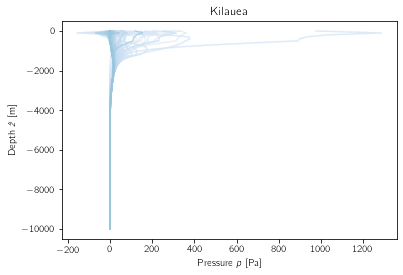

In [74]:
# %%time 
'''
Model parameters and implementation for 3-domain half-space (permeable layer overlying less permeable layers)
'''
del_t = 1000 # grid size for time (s)  
dy = 100 # grid size for space (m)
u_3_stage = np.zeros((101,len(file_dates)))

######### domain 1 [shallow, permeable]  #########
ny, nt, diffusivity, y_max, y, u, num_it  = parameters(top_depth=0, k=ki[0], phi=0.2, iterations = len(pz0))
p = np.zeros((ny,))
m= -1
print("Layer 1")
for num in range(num_it):
    if num % int(np.ceil(num_it/100)) == 0:
        m+=1
        print('{:02d}% | '.format(np.arange(1,101)[m]), sep=' ', end=' ', flush=True)
    p[0] = pz0[num]
    pout, s = diffusion_Crank_Nicolson(dy,ny,del_t,nt,diffusivity,p)
    u[num] = pout[0]
u_3_stage[0:6] = u.T[0:6]
p_new = u.T[5]

######### domain 2 [deeper, less permeable]  #########
ny, nt, diffusivity, y_max, y, u, num_it  = parameters(top_depth=500, k=ki[1], phi=0.2, iterations = len(pz0))
p = np.zeros((ny,))
m= -1
print("\nLayer 2")
for num in range(num_it):
    if num % int(np.ceil(num_it/100)) == 0:
        m+=1
        print('{:02d}% | '.format(np.arange(1,101)[m]), sep=' ', end=' ', flush=True)
    p[0] = p_new[num]
    pout, s = diffusion_Crank_Nicolson(dy,ny,del_t,nt,diffusivity,p)
    u[num] = pout[0]
u_3_stage[5::] = u.T
p_new = u.T[7]
######### domain  [deeper, less permeable]  #########
ny, nt, diffusivity, y_max, y, u, num_it  = parameters(top_depth=1200, k=ki[2], phi=0.01, iterations = len(pz0))
p = np.zeros((ny,))
m= -1
print("\nLayer 3")
for num in range(num_it):
    if num % int(np.ceil(num_it/100)) == 0:
        m+=1
        print('{:02d}% | '.format(np.arange(1,101)[m]), sep=' ', end=' ', flush=True)
    p[0] = p_new[num]
    pout, s = diffusion_Crank_Nicolson(dy,ny,del_t,nt,diffusivity,p)
    u[num] = pout[0]
u_3_stage[12::] = u.T

y = np.arange(0,1e4+dy,dy)

max_u_3 = []
for j,k in enumerate(y):
    max_u_3.append(max(u_3_stage[j]))
    
for num in range(len(y)):
    plt.plot(u_3_stage[:,num],-y, color = plt.cm.Blues(num), alpha = 0.85)
plt.ylabel("Depth $\hat{z}$ [m]")
plt.xlabel("Pressure $p$ [Pa]")
plt.title("{}".format(name_volc))
plt.show()      


Layer 1
01% |  02% |  03% |  04% |  05% |  06% |  07% |  08% |  09% |  10% |  11% |  12% |  13% |  14% |  15% |  16% |  17% |  18% |  19% |  20% |  21% |  22% |  23% |  24% |  25% |  26% |  27% |  28% |  29% |  30% |  31% |  32% |  33% |  34% |  35% |  36% |  37% |  38% |  39% |  40% |  41% |  42% |  43% |  44% |  45% |  46% |  47% |  48% |  49% |  50% |  51% |  52% |  53% |  54% |  55% |  56% |  57% |  58% |  59% |  60% |  61% |  62% |  63% |  64% |  65% |  66% |  67% |  68% |  69% |  70% |  71% |  72% |  73% |  74% |  75% |  76% |  77% |  78% |  79% |  80% |  81% |  82% |  83% |  84% |  85% |  86% |  87% |  88% |  89% |  90% |  91% |  92% |  93% |  94% |  95% |  96% |  97% |  98% |  99% |  100% |  

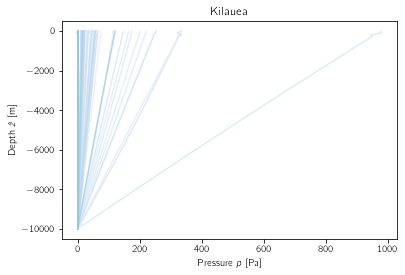

In [115]:
'''
Model parameters and implementation for single-domain half-space (arithmetic permeability)
'''
del_t = 1000 # grid size for time (s)  
dy = 100 # grid size for space (m)
u_kx = np.zeros((101,len(file_dates)))

######### domain 1 [arithmetic permeability]  #########
ny, nt, diffusivity, y_max, y, u, num_it  = parameters(top_depth=0, k=kx, phi=0.2, iterations = len(pz0))
p = np.zeros((ny,))
m= -1
print("Layer 1")
for num in range(num_it):
    if num % int(np.ceil(num_it/100)) == 0:
        m+=1
        print('{:02d}% | '.format(np.arange(1,101)[m]), sep=' ', end=' ', flush=True)
    p[0] = pz0[num]
    pout, s = diffusion_Crank_Nicolson(dy,ny,del_t,nt,diffusivity,p)
    u[num] = pout[0]
u_kx = u.T.copy()


y = np.arange(0,1e4+dy,dy) 
max_u_kx = []
for j,k in enumerate(y):
    max_u_kx.append(max(u_kx[j]))
 
for num in range(len(y)):
    plt.plot(u_kx[:,num],-y, color = plt.cm.Blues(num), alpha = 0.85)
plt.ylabel("Depth $\hat{z}$ [m]")
plt.xlabel("Pressure $p$ [Pa]")
plt.title("{}".format(name_volc))
plt.show()      


Layer 1
01% |  02% |  03% |  04% |  05% |  06% |  07% |  08% |  09% |  10% |  11% |  12% |  13% |  14% |  15% |  16% |  17% |  18% |  19% |  20% |  21% |  22% |  23% |  24% |  25% |  26% |  27% |  28% |  29% |  30% |  31% |  32% |  33% |  34% |  35% |  36% |  37% |  38% |  39% |  40% |  41% |  42% |  43% |  44% |  45% |  46% |  47% |  48% |  49% |  50% |  51% |  52% |  53% |  54% |  55% |  56% |  57% |  58% |  59% |  60% |  61% |  62% |  63% |  64% |  65% |  66% |  67% |  68% |  69% |  70% |  71% |  72% |  73% |  74% |  75% |  76% |  77% |  78% |  79% |  80% |  81% |  82% |  83% |  84% |  85% |  86% |  87% |  88% |  89% |  90% |  91% |  92% |  93% |  94% |  95% |  96% |  97% |  98% |  99% |  100% |  

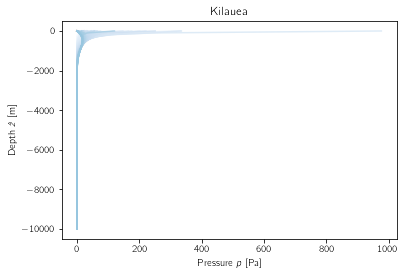

In [116]:
'''
Model parameters and implementation for single-domain half-space (geometric permeability)
'''
del_t = 1000 # grid size for time (s)  
dy = 100 # grid size for space (m)
u_kg = np.zeros((101,len(file_dates)))

######### domain 1 [geometric permeability]  #########
ny, nt, diffusivity, y_max, y, u, num_it  = parameters(top_depth=0, k=kg, phi=0.2, iterations = len(pz0))
p = np.zeros((ny,))
m= -1
print("Layer 1")
for num in range(num_it):
    if num % int(np.ceil(num_it/100)) == 0:
        m+=1
        print('{:02d}% | '.format(np.arange(1,101)[m]), sep=' ', end=' ', flush=True)
    p[0] = pz0[num]
    pout, s = diffusion_Crank_Nicolson(dy,ny,del_t,nt,diffusivity,p)
    u[num] = pout[0]
u_kg = u.T.copy()


y = np.arange(0,1e4+dy,dy) 
max_u_kg = []
for j,k in enumerate(y):
    max_u_kg.append(max(u_kg[j]))
 
for num in range(len(y)):
    plt.plot(u_kg[:,num],-y, color = plt.cm.Blues(num), alpha = 0.85)
plt.ylabel("Depth $\hat{z}$ [m]")
plt.xlabel("Pressure $p$ [Pa]")
plt.title("{}".format(name_volc))
plt.show()      


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


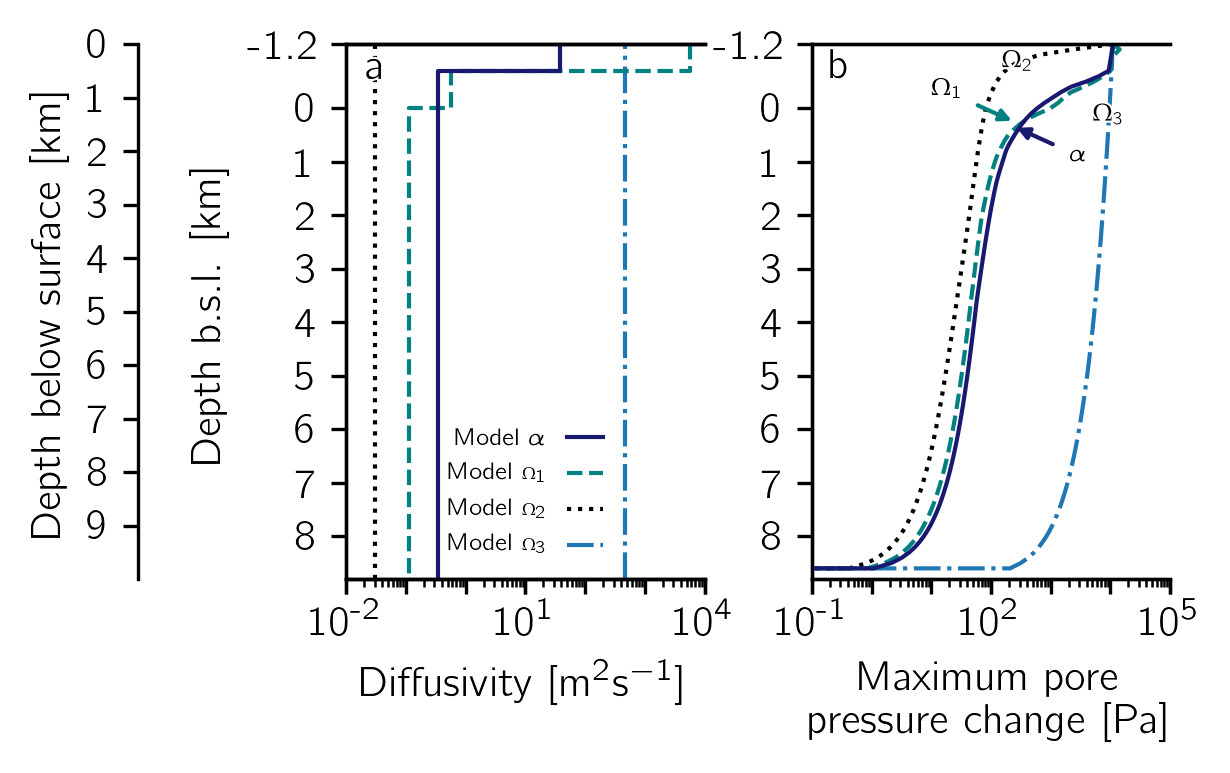

In [81]:
'''
Plots Figure 3, diffusivities of discrete models and maximum pressure change effected at depth.
'''  
fig = plt.figure(1, figsize=(mm2inch(90,60)), frameon=True, dpi=300)
plt.rcParams["font.family"] = 'sans-serif'
ax1= fig.add_subplot(121)
variable_diff = []
for z in range(len(y)):
    if z < int(500/y_max*len(y)):
        variable_diff.append(alpha(k=ki[0]))
    elif z < int(1200/y_max*len(y)):
        variable_diff.append(alpha(k=ki[1]))
    else    :
        variable_diff.append(alpha(k=ki[2], phi = 0.01))
variable_diff2 = []
for z in range(len(y)):
    if z < int(500/y_max*len(y)):
        variable_diff2.append(alpha(k=1e-12, phi=0.3))
    else    :
        variable_diff2.append(alpha(k=6e-15, phi = 0.2))


ax1.step(variable_diff2, y, "midnightblue", linestyle = "solid", label = r"Model $\alpha  $", zorder = 10, linewidth = 1)
ax1.step(variable_diff, y, "teal", label = r'Model {\fontsize{4pt}{3em}$\Omega$}$_1$', linestyle="dashed",linewidth = 1, zorder = 9)
ax1.axvline(x=alpha(k=kg, phi = 0.2), color="k", linestyle = ":",zorder = 0, label = r'Model {\fontsize{4pt}{3em}$\Omega$}$_2$', linewidth = 1)
ax1.axvline(x=alpha(k=kx, phi = 0.2), linestyle = "-.", zorder = 0, label = r'Model {\fontsize{4pt}{3em}$\Omega$}$_3$', linewidth = 1)


ax1.set_xscale("log")
ax1.set_xlabel(r"Diffusivity [m$^2$s$^{-1}$]")
ax1.set_ylabel(r"Depth b.s.l. [km]")
ax1.set_ylim([10000,0])

ax1.set_xlim([1e-4,1e4])
plt.legend(fancybox = "None",edgecolor="None", loc = 8,facecolor = "w",
           markerfirst = False, framealpha=0., handlelength = 1.5,
          fontsize="xx-small").set_zorder(12)
ax2 = fig.add_subplot(122)

ax2.plot(max_u_comb,y, "midnightblue", linestyle = "solid", linewidth = 1, zorder = 10)
ax2.plot(max_u_kg,y, "k", linestyle = ":", linewidth = 1)
ax2.plot(max_u_3,y, "teal", linewidth = 1, linestyle = "dashed")
ax2.plot(max_u_kx,y, linestyle = "-.", zorder = 0, linewidth = 1)
ax2.set_xscale("log")
ax2.set_ylim([10000,0])
ax2.set_xlabel("Maximum pore\npressure change [Pa]")
ax2.yaxis.label.set_visible(False)
ax2.set_xlim([1e-1,1e5])

plt.rcParams["font.family"] = 'sans-serif'
ax1.xaxis.set_major_formatter(LogFormatterTexTextMode())
ax2.xaxis.set_major_formatter(LogFormatterTexTextMode())

ax1.annotate("a", xy=(2e-2,650),xycoords = "data", weight = "bold", path_effects = buffer)
ax2.annotate("b", xy=(2e-1,650),xycoords = "data", weight = "bold")

plt.subplots_adjust(wspace=0.3)#52)

ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(-1*(-x/1000+1.2)))
ax1.yaxis.set_major_formatter(ticks_y)
ax1.set_yticks([0,1200,2200,3200,4200,5200,6200,7200,8200, 9200])
ax1.set_yticklabels([-1.2, 0, 1, 2, 3, 4, 5, 6, 7, 8])
ax2.yaxis.set_major_formatter(ticks_y)
ax2.set_yticks([0,1200,2200,3200,4200,5200,6200,7200,8200, 9200])
ax2.set_yticklabels([-1.2, 0, 1, 2, 3, 4, 5, 6, 7, 8])

ax3 = ax1.twinx()
ax3.set_ylim([10,0])
ax3.set_yticks([0,1,2,3,4,5,6, 7, 8, 9 ])
ax3.set_ylabel(r"Depth below surface [km]")
ax3.spines['left'].set_position(('outward', 50))
ax3.yaxis.set_label_position("left")
ax3.yaxis.tick_left()
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x))
ax3.yaxis.set_major_formatter(ticks_y)
ax1.spines["right"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax3.spines["right"].set_visible(False)

locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax1.xaxis.set_major_locator(locmaj)
ax2.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(np.arange(0.1,1,0.1)),numticks=12)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax2.xaxis.set_minor_locator(locmin)
ax2.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax1.set_xticks([1e-2,1e1,1e4])
ax2.set_xticks([1e-1,1e2,1e5])
ax1.set_xlim([1e-2,1e4])
ax4 = ax1.twiny()
ax4.xaxis.tick_bottom()
ax4.set_xlim([1e-2,1e4])
ax4.set_xscale("log")
ax4.xaxis.set_major_locator(locmaj)
ax4.set_xticklabels([])
ax5 = ax2.twiny()
ax5.xaxis.tick_bottom()
ax5.set_xlim([1e-1,1e5])
ax5.set_xscale("log")
ax5.xaxis.set_major_locator(locmaj)
ax5.set_xticklabels([])
ax4.spines["right"].set_visible(False)
ax5.spines["right"].set_visible(False)
ax2.annotate(r"$\alpha$", xy=(200,1500),xycoords = "data", fontsize = "xx-small",
            xytext=(2e3,2.2e3),
            arrowprops={'arrowstyle': '-|>', 'color' : "midnightblue"})#, path_effects = buffer)

ax2.annotate(r'$\Omega_1$', xy=(300,1500),xycoords = "data", fontsize = "xx-small",
            xytext=(1e1,1e3),
            arrowprops={'arrowstyle': '-|>', 'color' : "teal"})
ax2.annotate(r'$\Omega_2$', xy=(150,500),xycoords = "data", fontsize = "xx-small", path_effects = buffer)
ax2.annotate(r'$\Omega_3$', xy=(5e3,1500),xycoords = "data", fontsize = "xx-small", path_effects = buffer)

# plt.savefig(filepath+"/figures/kil_fig_3.pdf", bbox_inches='tight')
plt.show()

**Figure 3 |** a Diffusivity (a function of permeability k , bulk modulus K , fluid viscosity μ , and porosity φ given by kK/μφ ) against depth (depth below the surface and depth b.s.l. are shown for reference) for four different models ( k − φ scenarios, summarised in Table 1). The primary model (Model α ) is a
two-layer model, with a zone of high porosity and permeability overlying a lower permeability domain.
Reference model Ω subdivides the lower domain into two, each with different properties. Models 1 Ω2
and Ω are single-domain models, meaning that they use values of porosity, permeability, bulk 3
modulus, and viscosity that are constant with depth. Further detail is given in the Methods. b The
maximum pressure change effected at depth in each model throughout the modelled time-series. Note
that the maximum pressure change for any given depth can occur on multiple dates, and may not be
consecutive. For example, high values near the surface may occur frequently (see Fig. 4a, b) but may not
propagate to depth. On the other hand, high pressure at depth may not be a direct consequence of a
single spike at the surface.

Layer 1
01% |  02% |  03% |  04% |  05% |  06% |  07% |  08% |  09% |  10% |  11% |  12% |  13% |  14% |  15% |  16% |  17% |  18% |  19% |  20% |  21% |  22% |  23% |  24% |  25% |  26% |  27% |  28% |  29% |  30% |  31% |  32% |  33% |  34% |  35% |  36% |  37% |  38% |  39% |  40% |  41% |  42% |  43% |  44% |  45% |  46% |  47% |  48% |  49% |  50% |  51% |  52% |  53% |  54% |  55% |  56% |  57% |  58% |  59% |  60% |  61% |  62% |  63% |  64% |  65% |  66% |  67% |  68% |  69% |  70% |  71% |  72% |  73% |  74% |  75% |  76% |  77% |  78% |  79% |  80% |  81% |  82% |  83% |  84% |  85% |  86% |  87% |  88% |  89% |  90% |  91% |  92% |  93% |  94% |  95% |  96% |  97% |  98% |  99% |  100% |  
Layer 2
01% |  02% |  03% |  04% |  05% |  06% |  07% |  08% |  09% |  10% |  11% |  12% |  13% |  14% |  15% |  16% |  17% |  18% |  19% |  20% |  21% |  22% |  23% |  24% |  25% |  26% |  27% |  28% |  29% |  30% |  31% |  32% |  33% |  34% |  35% |  36% |  37% |  38% |  39% |  40% |  41

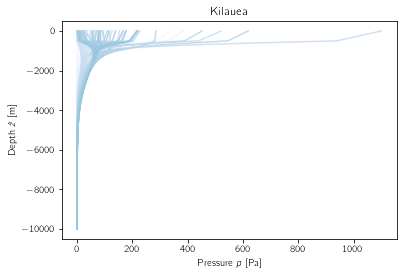

CPU times: user 50min 52s, sys: 26min 19s, total: 1h 17min 11s
Wall time: 21min 49s


In [83]:
%%time
'''
Model parameters and implementation for 2-domain half-space (permeable layer overlying less permeable layer),
over long time-frame (gauge data only)
'''

lt_rainfall_m=lt_ki_rain.rain/1e3

pzlt = []
rho = 997.
g = 9.80665
for j,k in enumerate(lt_rainfall_m):
    pzlt.append(lt_rainfall_m[j]*rho*g) # pressure defined as a pseudovector, assuming the height of rainfall (in m), the density of water, and acceleration due to gravity.
pzlt = [0 if np.isnan(x) else x for x in pzlt]

del_t = 1000 # grid size for time (s)  
dy = 100 # grid size for space (m)
u_comb_lt = np.zeros((101,len(lt_ki_rain.date)))

######### domain 1 [shallow, permeable]  #########
ny, nt, diffusivity, y_max, y, u, num_it  = parameters(top_depth=0, k=1e-12, phi=0.3, iterations = len(pzlt))
p = np.zeros((ny,))
m= -1
print("Layer 1")
for num in range(num_it):
    if num % int(np.ceil(num_it/100)) == 0:
        m+=1
        print('{:02d}% | '.format(np.arange(1,101)[m]), sep=' ', end=' ', flush=True)
    p[0] = pzlt[num]
    pout, s = diffusion_Crank_Nicolson(dy,ny,del_t,nt,diffusivity,p)
    u[num] = pout[0]
u_comb_lt[0:6] = u.T[0:6]
p_new = u.T[5]

######### domain 2 [deeper, less permeable]  #########
ny, nt, diffusivity, y_max, y, u, num_it  = parameters(top_depth=500, k=6e-15, phi=0.2, iterations = len(pzlt))
p = np.zeros((ny,))
m= -1
print("\nLayer 2")
for num in range(num_it):
    if num % int(np.ceil(num_it/100)) == 0:
        m+=1
        print('{:02d}% | '.format(np.arange(1,101)[m]), sep=' ', end=' ', flush=True)
    p[0] = p_new[num]
    pout, s = diffusion_Crank_Nicolson(dy,ny,del_t,nt,diffusivity,p)
    u[num] = pout[0]
u_comb_lt[5::] = u.T

y = np.arange(0,1e4+dy,dy) 
 
for num in range(len(y)):
    plt.plot(u_comb_lt[:,num],-y, color = plt.cm.Blues(num), alpha = 0.85)
plt.ylabel("Depth $\hat{z}$ [m]")
plt.xlabel("Pressure $p$ [Pa]")
plt.title("{}".format(name_volc))
plt.show()      


In [84]:
kilauea_intrusions_all =[
    "1963-05-09",
    "1963-07-02",
    "1965-08-25",
    "1969-03-21",
    "1969-07-03",
    "1969-11-03",
    "1970-01-22",
    "1973-06-09",
    "1974-03-24",
    "1976-06-21",
    "1976-07-14",
    "1977-02-08",
    "1979-05-29",
    "1980-03-02",
    "1980-07-30",
    "1980-08-27",
    "1980-10-22",
    "1980-11-02",
    "1981-08-10",
    "1982-03-23",
    "1982-06-22",
    "1982-12-09",
    "1969-10-07",
    "1971-12-23",
    "1981-01-20",
    "1981-01-24",
    "1981-02-09",
    "1981-08-02",
    "1990-12-04",
    "1991-03-26",
    "1991-08-21",
    "1992-03-03",
    "1993-02-07",
    "1997-01-29",
    "1999-09-12",
    "1979-08-12",
    "1980-10-21",    
    "2000-02-23",
    "2007-06-17",
    "2011-03-05",
    "2011-08-03",
    "2011-09-21",
    "2012-10-15"]

In [85]:
'''
Calculate 4 year rolling mean pressure
'''
yrs = 4
roll_mean_lt = pd.DataFrame(u_comb_lt[30]).rolling(int(yrs*365)).mean()
roll_mean = pd.DataFrame(u_combined[30]).rolling(int(yrs*365)).mean()


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


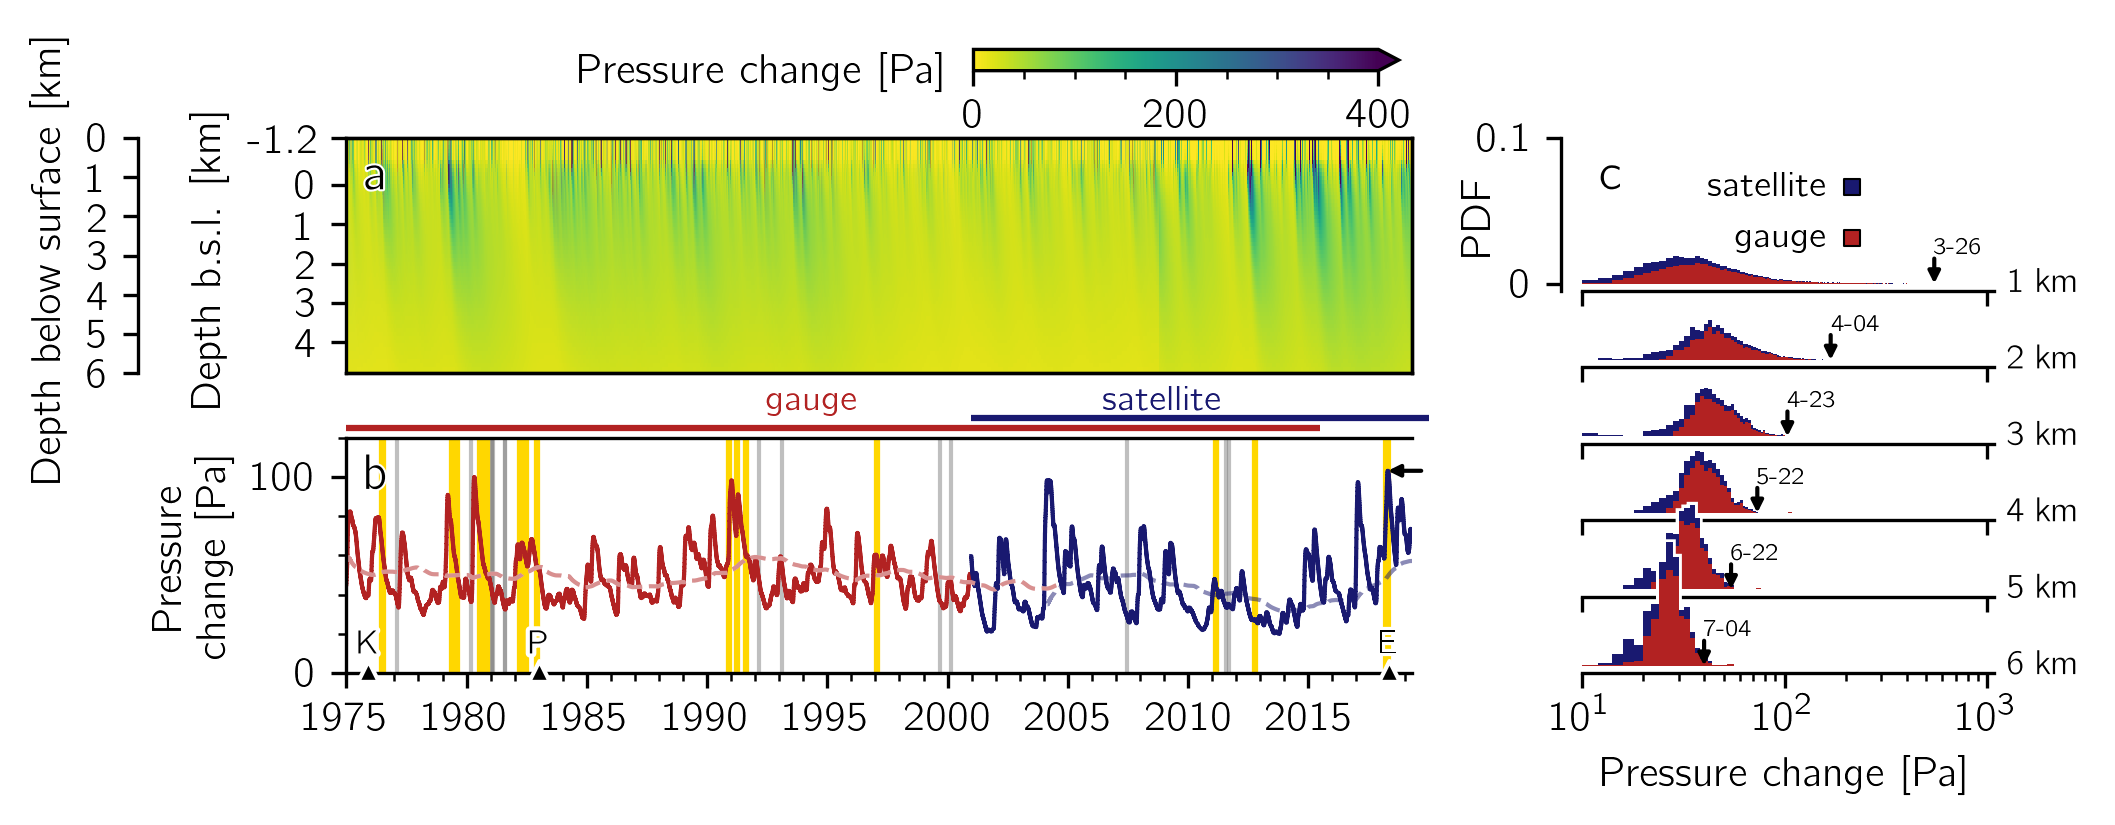

In [86]:
'''
Plots figure 4. Panel a: modelled pressure change as a function of time and depth;
Panel b: modelled pressure change at a depth of 3 km below the surface;
Panel c: probability distribution functions of modelled pressure changes at depths of 1-6 km below the surface.
'''

x_lims = [min(lt_ki_rain.date),max(lt_ki_rain.date)]
x_lims = mdates.date2num(x_lims)
x_lims2 = [min(file_dates),max(file_dates)]
x_lims2 = mdates.date2num(x_lims2)
x_lims3 = [file_dates[300],max(file_dates)]
x_lims3 = mdates.date2num(x_lims3)
lim_75 = mdates.date2num(lt_ki_rain.date[9190])

fig = plt.figure(1, figsize=(mm2inch(180,60)), frameon=True, dpi=300)

gs0 = plt.GridSpec(6, 17, figure=fig, wspace=0,hspace=1.8
                 )

gs = plt.GridSpec(6, 4, figure=fig, wspace=0, hspace=-.5
                 )

axs = [fig.add_subplot((gs0[0:3,0:-6])),
       fig.add_subplot((gs0[3:7,0:-6])),
       fig.add_subplot((gs[0,-1])),
       fig.add_subplot((gs[1,-1])),
       fig.add_subplot((gs[2,-1])),
       fig.add_subplot((gs[3,-1])),
       fig.add_subplot((gs[4,-1])),
       fig.add_subplot((gs[5,-1])),
      ]
############ set up axes formatting ##############

ml = ticker.MultipleLocator(20)
years = mdates.YearLocator() 
months = mdates.MonthLocator() 
monthsFmt = mdates.DateFormatter("%b")
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(np.arange(0.1,1,0.1)),numticks=12)

################# bgn panel a ###################

axs[0].get_xaxis().set_ticks([])
axs[0].set_ylabel(r'Depth b.s.l. [km]')
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((-(-(x-40)*dy+1200)/1000)))
axs[0].yaxis.set_major_formatter(ticks_y)

ax0b = axs[0].twinx()
ax0b.set_ylim([6,0])
ax0b.set_yticks([0,1,2,3,4,5, 6])
ax0b.set_ylabel(r"Depth below surface [km]")
ax0b.spines['left'].set_position(('outward', 50))
ax0b.yaxis.set_label_position("left")
ax0b.yaxis.tick_left()
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x))
ax0b.yaxis.set_major_formatter(ticks_y)


im = axs[0].imshow(u_combined, cmap = 'viridis_r', vmin = 0, vmax = 400,
          extent=[x_lims3[0],x_lims3[1],0,100], aspect = 'auto', alpha = 1)


axs[0].imshow(u_comb_lt, cmap = 'viridis_r', vmin = 0, vmax = 400,
          extent=[x_lims[0],x_lims[1],0,100], aspect = 'auto', alpha = 1)
axs[0].imshow(u_combined, cmap = 'viridis_r', vmin = 0, vmax = 400,
          extent=[x_lims3[0],x_lims3[1],0,100], aspect = 'auto', alpha = .3)

ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((-x+100)/10-1.2))


axs[0].set_ylim(40,100)
axs[0].yaxis.set_major_formatter(ticks_y)
axs[0].set_yticks([48,58,68,78,88,100])

# ####### panel a annotations #######

################# end panel a ###################

axs[1].step(lt_ki_rain.date[:18680], u_comb_lt[30][:18680], color = "firebrick", lw =1, alpha = 1., clip_on = True, where = 'mid')#, path_effects=buffer)
axs[1].step(file_dates[300::], u_combined[30][300::], color = "midnightblue", lw = 1, linestyle = "solid", where = 'mid')#, path_effects=buffer)
axs[1].bar(kilauea_intrusions_all, height = 200, edgecolor = "grey", width = 0.1, zorder = 0, alpha = 0.5, color = None)
axs[1].set_ylabel("Pressure\nchange [Pa]")
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x))
axs[1].yaxis.set_major_formatter(ticks_y)
axs[1].fill_between(file_dates[6588:6640],200, 
                 color = "gold", 
                 edgecolor = "None",
                )

axs[1].annotate(r"gauge", xy = ("06-01-1992", 100), color ='firebrick',
                xycoords = "data", fontsize = "small", xytext = ("06-01-1992", 134))
axs[1].annotate(r"satellite", xy = ("06-01-2009", 100), color = 'midnightblue',
                xycoords = "data", fontsize = "small", xytext = ("06-01-2006", 134))
axs[1].spines['right'].set_visible(False)
axs[1].hlines(y = 125, xmin = "1975-01-01", xmax = max(lt_ki_rain.date[:]), clip_on = False, color = "firebrick")
axs[1].hlines(y = 130, xmin = file_dates[300], xmax = max(file_dates), clip_on = False, color = "midnightblue")
axs[1].xaxis.set_label_position('bottom')
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x))
axs[1].yaxis.set_major_formatter(ticks_y)

axs[1].step(lt_ki_rain.date[:20000], roll_mean_lt[:20000], color = "firebrick",
            linewidth = 1, linestyle = "dashed", alpha = .5, path_effects=buffer, where = 'mid')
axs[1].step(file_dates[100::], roll_mean[100::],
            color = "midnightblue", linewidth = 1, linestyle = "dashed", alpha = .5, where = 'mid')
axs[1].set_xlim(["1975-01-01", "2019-05-01"])

axs[1].set_ylim([0,120])
cnt = sum(j < 1975 for j in ([int(k[0:4]) for k in kilauea_intrusions_all]))
for num in kilauea_intrusions_all:
    if int(num[0:4]) >= 1975:
        if u_comb_lt[30][[str(x) for x in lt_ki_rain.date].index(num)] >= roll_mean_lt[0][[str(x) for x in lt_ki_rain.date].index(num)]:
            axs[1].axvline(x=num, color = "gold", zorder =1, alpha = 1) 
for num in kilauea_intrusions_all:
    if int(num[0:4]) >= 2002:
        if u_combined[30][[str(x) for x in ki_rain.date].index(num)] >= roll_mean[0][[str(x) for x in ki_rain.date].index(num)]:
            axs[1].axvline(x=num, color = "gold", zorder =1, alpha = 1)   


axs[1].xaxis.set_minor_locator(years)
axs[1].yaxis.set_minor_locator(ml)
#########
####### panel b annotations #######

axs[1].annotate("K", fontsize = 8, xy = ("1975-11-29", 10), path_effects = [patheffects.withStroke(linewidth=2, foreground="w")], ha = 'center')
axs[1].annotate("P", fontsize = 8, xy = ("1983-01-03", 10), path_effects = [patheffects.withStroke(linewidth=2, foreground="w")], ha = 'center', zorder = 11)
axs[1].annotate("E", fontsize = 8, xy = ("2018-05-03", 10), path_effects = [patheffects.withStroke(linewidth=1.5, foreground="w")], ha = 'center', zorder = 11)
axs[1].annotate("33", fontsize = 4, xy = ("2018-03-15", 145), path_effects = buffer, ha = "center")
for num, label in enumerate(STRING.ascii_lowercase[0:3]):
    axs[num].annotate(label, (0, 1),xytext=(4, -4),
                      xycoords='axes fraction',textcoords='offset points',
    color='k',fontsize = 12, path_effects = buffer,ha='left', va='top', zorder = 1000)

####### panel b annotations #######
################# end panel b ###################

################# bgn panel a ###################
MAX = max(u_combined[10])
MIN = 0
binwidth = 2
depths = [10,20,30, 40, 50 , 60]
m = 2
offset = 0
for z in depths:
    lt_p_data = u_comb_lt[z][:18680]
    u_data = u_combined[z]
    
    all_p_data = list(lt_p_data)
    all_p_data.extend(u_data)
    axs[m].hist(all_p_data, bins=np.arange(MIN,MAX + binwidth, binwidth),
                            density = True, histtype = "step", ec ="w", lw = 1.5)

    axs[m].hist([lt_p_data,u_data],
                bins=np.arange(MIN,MAX + binwidth, binwidth),
        stacked=True, density=True, color = ["firebrick", "midnightblue"], lw = 0)
    
    axs[m].set_xlim(1e1, MAX)
    axs[m].set_ylim(-0.005,0.1)
    axs[m].spines["right"].set_visible(False)
    axs[m].spines["top"].set_visible(False)
    axs[m].spines["left"].set_visible(False)
    axs[m].spines["left"].set_position(("axes", (offset-.05)))
    axs[m].set_yticks([0,0.1])
    axs[m].minorticks_on
    axs[m].set_xticklabels([])
    axs[m].tick_params(labelbottom=False)
    axs[m].tick_params(labelleft=False) 
    axs[m].tick_params(left= False)
    axs[m].annotate("{} km".format(int(z/10)), xy=(MAX,0),xycoords = "data",
                        xytext=(3, -2),textcoords='offset points',
                        fontsize = 'small', path_effects = buffer)
    axs[m].annotate('', xy=(max(u_combined[z][6515:6700]),0),
                xycoords = "data", fontsize = "xx-small",
                xytext=(0,8),textcoords='offset points',
            arrowprops={'arrowstyle': '-|>', 'color' : "k", 'shrinkB' : 0})
    
    alignments = ['none','right','left','left','left','left']
    date = str(file_dates[np.argmax(u_combined[z][6515:6700])+6515])[-4:]
    axs[m].annotate("{}".format(date), 
                    xy=(max(u_combined[z][6515:6700]),0.02),
                xycoords = "data", fontsize = 'xx-small', ha = 'left')#ha = alignments[m])
    axs[m].set_xscale("log")
    axs[m].set_facecolor("None")
    m+=1
    offset+=.055
axs[2].set_yticks([0,0.1]) 
axs[2].tick_params(left= True)
axs[2].tick_params(labelleft=True)
axs[2].set_ylabel("PDF", labelpad=-5)
axs[2].spines["left"].set_visible(True)
axs[2].set_yticklabels([0,0.1]) 
axs[m-1].tick_params(labelbottom=True)

axs[m-1].set_xlabel("Pressure change [Pa]")
axs[m-1].tick_params(bottom= True)

axs[2].scatter([],[], marker = 's',s=16, ec='k', lw = .5,color = 'midnightblue', label = 'satellite')
axs[2].scatter([],[], marker = 's',s=16, ec='k', lw = .5, color = 'firebrick', label = 'gauge')
axs[2].legend(fancybox = "None",edgecolor="None",
              loc = 9,
              facecolor = "w",
           markerfirst = False, framealpha=0., handlelength = 1,
          fontsize="small", ncol=1, handletextpad=.25, columnspacing=1).set_zorder(12)


axs[m-1].xaxis.set_major_formatter(LogFormatterTexTextMode())
axs[m-1].xaxis.set_major_locator(locmaj)
axs[m-1].xaxis.set_minor_locator(locmin)
################# end panel c ###################

axs[1].annotate('', xy=(file_dates[np.argmax(u_combined[30])], np.max(u_combined[30])),
                xycoords = "data", fontsize = "xx-small",
                xytext=(10,0),textcoords='offset points',
            arrowprops={'arrowstyle': '-|>', 'color' : "k", 'shrinkB' : 0})



cbar_ax = fig.add_axes([0.42,0.975, 0.2, 0.03])
fig.colorbar(im, cax=cbar_ax, extend = "max", orientation = "horizontal")
cbar_ax.set_ylabel('Pressure change [Pa]', rotation = 0, labelpad = 50, y = -1)

cbar_ax.minorticks_on()
cbar_ax.yaxis.set_major_formatter(ticks_y)
axs[1].scatter("1975-11-29", 1, marker = "^", color = "k",ec = "w",lw=1, s=25, clip_on=False, zorder = 999)
axs[1].scatter("1983-01-03", 1, marker = "^", color = "k",ec = "w",lw=1, s=25, clip_on=False, zorder = 999)
axs[1].scatter("2018-05-03", 1, marker = "^", color = "k",ec = "w",lw=1, s=25, clip_on=False, zorder = 999)


plt.savefig(filepath+"/figures/kil_fig_4.png", bbox_inches='tight')
plt.savefig(filepath+"/figures/kil_fig_4.pdf", bbox_inches='tight')
plt.tight_layout()

**Figure 4|** Rainfall infiltration into Kīlauea’s edifice. a Pore pressure change with depth and time, using
daily rainfall data (see Fig. 2a) as a fluctuating boundary condition. Color scale indicates pressure
change. b Pore pressure change at depths of 1, 2, 3, 4, 5, and 6 km below the surface over time. c
Detailed view of b, showing model results from Jan 2018 to Aug 2018. Diamonds indicate the maximum
value for each depth over that timeframe, illustrating the propagation of a pore pressure front from the
surface (1.2 km a.s.l.) to 4.8 km b.s.l. (i.e. from 0 to 6 km below the surface) over time. d Pore pressure
change at 3 km below the surface (1.8 km b.s.l.) modelled over the period Jan 1975–Apr 2019, using
available HVNP gauge data (1950–2015) and calibrated satellite data (2000–2019: see b). Dashed line is
the 4-year running average. K = 1975 M 7.2 Kalapana earthquake; P = 1983 onset of Pu‘u ‘Ō‘ō eruption; K
= 2018 Kīlauea rift intrusion–eruption. Numbered vertical bars indicate reported intrusion events within
the rift zone, after Klein et al. [1987] (1—19), Heliker and Mattox [2003] (20—27), Poland et al. [2014]
(28), and Orr et al. [2015] (29—32). Intrusions are highlighted in yellow if they coincide with periods
where pressure change exceeds the 4-year average, and grey if they do not. Intrusion 33 in this
time-series corresponds to the early 2018 activity (intrusion detected mid-March, followed by the rift
eruption on 3 May). Circle highlights the maximum pore pressure perturbation over this timeframe
(1975—2019), coinciding with the onset of 2018’s rift eruption. Horizontal bars indicate data availability.

In [88]:
'''
Read in supplementary data for the Paradise Parks/ Hawai`ian Beaches areas. Paradise data are well level data, Beaches data are rain gauge data. 
Paradise well level data are digitised from the Ph.D. thesis of Steve Gingerich: 
Gingerich, S.B., 1997. "The hydrothermal system of the Lower East Rift Zone of Kilauea Volcano: Conceptual and numerical models 
of energy and solute transport." University of Hawai`i at Manoa.

'''
paradise = pd.read_csv(filepath+"/gauge_data/paradise.csv", header=None, names=["Date", "level_m"],)
beaches = pd.read_csv(filepath+"/gauge_data/1768285.csv")

'''
Fix date formats
'''
bea = []
for x in beaches.DATE:
    bea.append(dt.datetime.strptime(x, "%Y-%m-%d"))
beaches["date"] = bea

para = []
for x in paradise.Date:
    para.append(dt.datetime.strptime(x, "%Y/%m/%d"))
paradise["date"]= para

'''
Convert rainfall to a pressure input
'''
beaches_m=beaches.PRCP/1e3 

pz0_b = []
rho = 997.
g = 9.80665
for j,k in enumerate(beaches_m):
    pz0_b.append(beaches_m[j]*rho*g) 
pz0_b = [0 if np.isnan(x) else x for x in pz0_b]

Layer 1
01% |  02% |  03% |  04% |  05% |  06% |  07% |  08% |  09% |  10% |  11% |  12% |  13% |  14% |  15% |  16% |  17% |  18% |  19% |  20% |  21% |  22% |  23% |  24% |  25% |  26% |  27% |  28% |  29% |  30% |  31% |  32% |  33% |  34% |  35% |  36% |  37% |  38% |  39% |  40% |  41% |  42% |  43% |  44% |  45% |  46% |  47% |  48% |  49% |  50% |  51% |  52% |  53% |  54% |  55% |  56% |  57% |  58% |  59% |  60% |  61% |  62% |  63% |  64% |  65% |  66% |  67% |  68% |  69% |  70% |  71% |  72% |  73% |  74% |  75% |  76% |  77% |  78% |  79% |  80% |  81% |  82% |  83% |  84% |  85% |  86% |  87% |  88% |  89% |  90% |  91% |  92% |  93% |  94% |  95% |  96% |  97% |  98% |  99% |  
Layer 2
01% |  02% |  03% |  04% |  05% |  06% |  07% |  08% |  09% |  10% |  11% |  12% |  13% |  14% |  15% |  16% |  17% |  18% |  19% |  20% |  21% |  22% |  23% |  24% |  25% |  26% |  27% |  28% |  29% |  30% |  31% |  32% |  33% |  34% |  35% |  36% |  37% |  38% |  39% |  40% |  41% |  42%

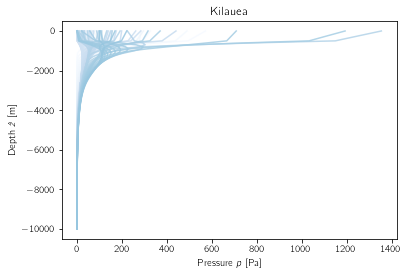

In [89]:
'''
Model parameters and implementation for 2-domain half-space (permeable layer overlying less permeable layer)
'''
del_t = 1000 # grid size for time (s)  
dy = 100 # grid size for space (m)
u_comb_para = np.zeros((101,len(pz0_b)))

######### domain 1 [shallow, permeable]  #########
ny, nt, diffusivity, y_max, y, u, num_it  = parameters(top_depth=0, k=1e-12, phi=0.3, iterations = len(pz0_b))
p = np.zeros((ny,))
m= -1
print("Layer 1")
for num in range(num_it):
    if num % int(np.ceil(num_it/100)) == 0:
        m+=1
        print('{:02d}% | '.format(np.arange(1,101)[m]), sep=' ', end=' ', flush=True)
    p[0] = pz0_b[num]
    pout, s = diffusion_Crank_Nicolson(dy,ny,del_t,nt,diffusivity,p)
    u[num] = pout[0]
u_comb_para[0:6] = u.T[0:6]
p_new = u.T[5]

######### domain 2 [deeper, less permeable]  #########
ny, nt, diffusivity, y_max, y, u, num_it  = parameters(top_depth=500, k=6e-15, phi=0.2, iterations = len(pz0_b))
p = np.zeros((ny,))
m= -1
print("\nLayer 2")
for num in range(num_it):
    if num % int(np.ceil(num_it/100)) == 0:
        m+=1
        print('{:02d}% | '.format(np.arange(1,101)[m]), sep=' ', end=' ', flush=True)
    p[0] = p_new[num]
    pout, s = diffusion_Crank_Nicolson(dy,ny,del_t,nt,diffusivity,p)
    u[num] = pout[0]
u_comb_para[5::] = u.T

y = np.arange(0,1e4+dy,dy) 

for num in range(len(y)):
    plt.plot(u_comb_para[:,num],-y, color = plt.cm.Blues(num), alpha = 0.85)
plt.ylabel("Depth $\hat{z}$ [m]")
plt.xlabel("Pressure $p$ [Pa]")
plt.title("{}".format(name_volc))
plt.show()      


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


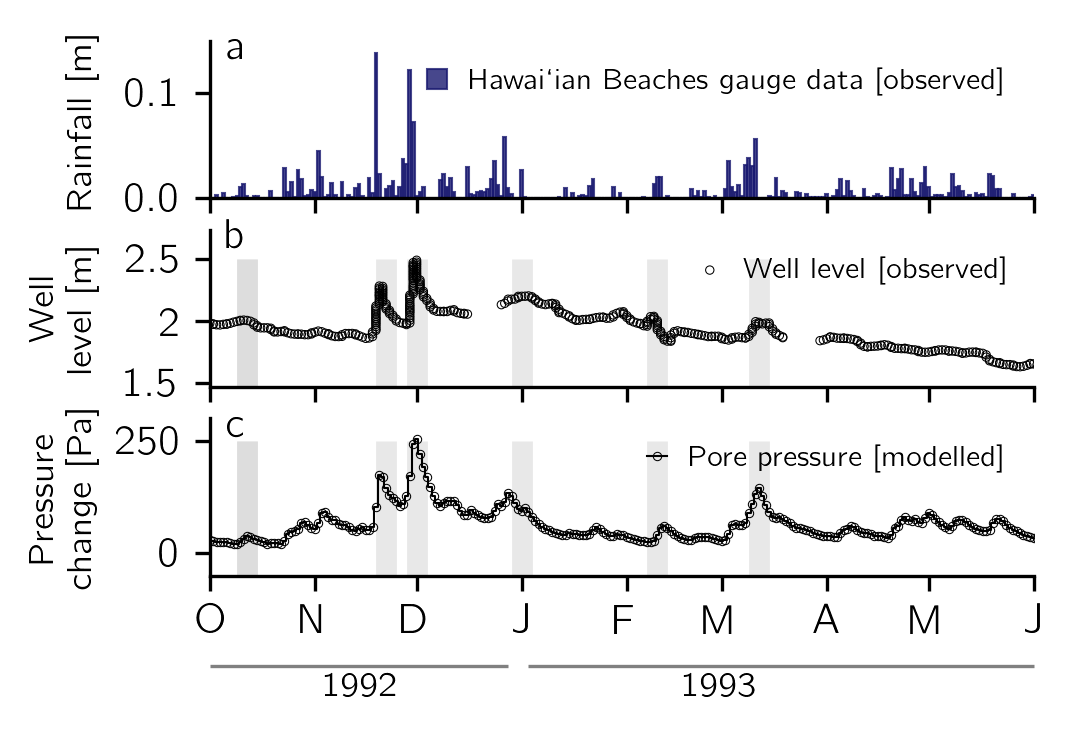

In [90]:
'''
Plots Extended data Figure 1: Comparison of modelled pore pressure change at depth and recorded well level data from Paradise Park.
'''
axlabels2= ["O", "N", "D", "J", "F", "M", "A", "M", "J", "J", "A", "S"]
fig =  plt.figure(figsize=(mm2inch(90,60)), frameon=True, dpi=300)
ax1 = fig.add_subplot(311)
ax1.bar(beaches.date, beaches_m, color="midnightblue", linewidth = .5, edgecolor = "midnightblue",alpha =0.8,
       label = "Hawai`ian Beaches gauge data [observed]")
legend = ax1.legend(fontsize = "x-small", edgecolor = "None", fancybox="None",
                    markerscale = .5, handlelength = 0.7, loc='upper right',
                   framealpha=0)
legend.get_frame().set_linewidth(0.8)
ax1.set_xlim(["1992-10-01", max(paradise.date)])

ax1.set_xticklabels([])
ax1.set_ylabel("Rainfall [m]", fontsize = "small")
ax1.annotate("a", xy = (0.02,0.88), xycoords="axes fraction")

ax3 = fig.add_subplot(312)
ax2 = fig.add_subplot(313)
ax3.scatter(paradise.date, paradise.level_m, facecolor = "None",linewidth = 0.25,color = "k", marker = "o",s = 4,
           label = "Well level [observed]")
ax3.set_ylabel("Well\nlevel [m]", fontsize = "small")
ax3.set_xticklabels([])
ax2.step(beaches.date[22:400], u_comb_para[10][22:400],
         color = "k" ,linewidth = .5, label = "Pore pressure [modelled]",
         where = 'mid',
        marker = "o",ms =2,mec = "k" , mfc="None",mew=.25)
ax2.set_xlim(["1992-10-01", max(paradise.date)])
ax3.set_xlim(["1992-10-01", max(paradise.date)])
ax2.set_ylabel("Pressure\nchange [Pa]", fontsize = "small")
axlabels= ["1992-10", "1992-11", "1992-12", "1993-01","1993-02","1993-03","1993-04","1993-05","1993-06","1993-07","1993-08","1993-09"]
ax2.set_xticks(axlabels)
ax2.set_xticklabels(axlabels2)
ax3.annotate("b", xy = (0.02,0.88), xycoords="axes fraction")
ax2.annotate("c", xy = (0.02,0.88), xycoords="axes fraction")
ax1.spines['right'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax2.set_ylim(0,250)
ax2.hlines(xmin="1992-10-01", xmax = "1992-12-28",y=-250, clip_on=False, linewidth = 0.8, color = "grey")
ax2.annotate("1992", xy = ("1992-11-01", 0),
             xycoords = 'data',xytext = ("1992-11-15", -320), ha = "center", clip_on=False, fontsize = "small")
ax2.hlines(xmin="1993-01-03", xmax = "1993-06",y=-250, clip_on=False, linewidth = 0.8, color = "grey")
ax2.annotate("1993", xy = ("1993-03-01", 0),
             xycoords = 'data',xytext = ("1993-03-01", -320), ha = "center", clip_on=False, fontsize = "small")

ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x))

ax2.yaxis.set_major_formatter(ticks_y)
ax3.yaxis.set_major_formatter(ticks_y)
ax1.set_ylim(0,.15)

ax3.set_ylim(1.47,2.74)

legend = ax2.legend(fontsize = "x-small", edgecolor = "None", fancybox="None",
                    markerscale = 1, handlelength = 0.7, loc='upper right',
                   framealpha=0)
legend.get_frame().set_linewidth(0.8)
legend = ax3.legend(fontsize = "x-small", edgecolor = "None", fancybox="None",
                    markerscale = 1, handlelength = 0.7, loc='upper right',
                   framealpha=0)
legend.get_frame().set_linewidth(0.8)
ax2.set_ylim(-50,300)
ax1.spines["top"].set_visible(False)
fig.align_ylabels()

peak_dates = ["1992-10-12","1992-10-12","1992-11-22","1992-12-01","1993-01-01","1993-02-10","1993-03-12"]
for date in peak_dates:
    ax3.vlines(date, ymin=0.25, ymax=2.5, linestyle="-", lw=5,color = "lightgrey", alpha = .5, zorder = 0)
    ax2.vlines(date, ymin=-50, ymax=250, linestyle="-", lw=5,color = "lightgrey", alpha = .5, zorder = 0)

ax1.set_xlim("1992-10", "1993-06")
ax2.set_xlim("1992-10", "1993-06")
ax3.set_xlim("1992-10", "1993-06")
plt.savefig("extended_data_figure_1.pdf", bbox_inches='tight')
plt.savefig("extended_data_figure_1.png", bbox_inches='tight')
plt.show()

**Extended Data Figure 1|** Comparison of recorded head change and modelled pressure change. a Rainfall
data obtained from the Hawai‘i Beaches rain gauge (refer to Fig. 1a [inset] for location). b
Paradise Park Well data (see Fig. 1a [inset] for location of well), digitised from Gingerich [1995]
over the time period Oct 1992–Sep 1993. c Pressure evolution at 1 km depth modelled using rain
data from a.

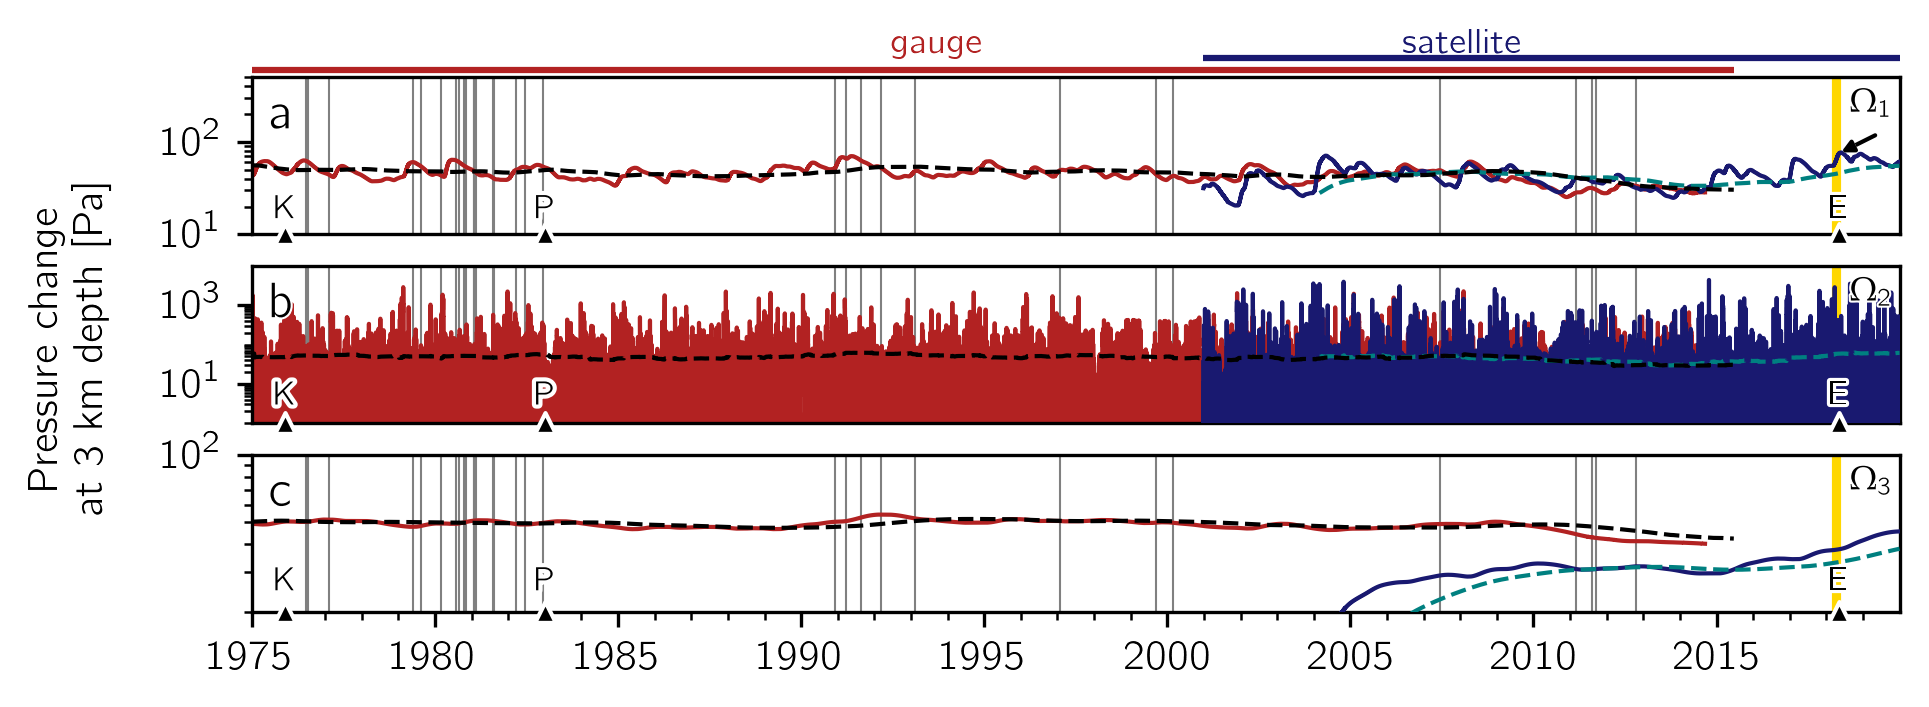

In [117]:
'''
Plots Extended data Figure 2 [panels a--c]: Time-series of pressure change at 3 km depth using different base parameters.
'''
fig = plt.figure(1, figsize=(mm2inch(180,60)), frameon=True, dpi=300)
axs = [plt.subplot2grid((3, 3), (0, 0), colspan = 3),
    plt.subplot2grid((3, 3), (1, 0), colspan = 3),
    plt.subplot2grid((3, 3), (2, 0), colspan = 3)]

lt_data = [u_3_stage_lt[30], u_kx_lt[30],u_kg_lt[30]]
st_data = [u_3_stage[30], u_kx[30],u_kg[30]]

for i in range(3):
    roll_mean_lt = pd.DataFrame(lt_data[i]).rolling(int(yrs*365)).mean()
    roll_mean = pd.DataFrame(st_data[i]).rolling(int(yrs*365)).mean()
    axs[i].step(lt_ki_rain.date[:-100], lt_data[i][:-100], color = "firebrick", lw=1)
    axs[i].plot(lt_ki_rain.date,roll_mean_lt, zorder = 999, ls="--", color = "k", alpha = 1, lw=1)
    num = len(file_dates)-len(st_data[i])
    if abs(num)>0:
        axs[i].step(file_dates[300:-num], st_data[i][300::], zorder = 9, color = "midnightblue", lw=1)
        axs[i].plot(file_dates[:-num],roll_mean, zorder = 100, ls="--", color = "teal", alpha = 1, lw=1)
    else:
        axs[i].step(file_dates[300::], st_data[i][300::], zorder = 9, color = "midnightblue", lw=1)
        axs[i].plot(file_dates,roll_mean, zorder = 100, ls="--", color = "teal", alpha = 1, lw=1)
    axs[i].set_xlim(xmin="1974-01-01", xmax = max(file_dates)) 
    axs[i].set_yscale("log")
    axs[i].annotate(r"$\Omega_{}$".format(i+1), (1, 1),xytext=(-12, -4),
                    xycoords='axes fraction',textcoords='offset points',
    color='k',fontsize = 8, path_effects = buffer,ha='left', va='top', zorder = 999)
    axs[i].annotate(r"{}".format(STRING.ascii_lowercase[i]), (0, 1),xytext=(4, -4),
                    xycoords='axes fraction',textcoords='offset points',
    color='k',fontsize = 12, path_effects = buffer,ha='left', va='top', zorder = 100)
    axs[i].yaxis.set_major_formatter(LogFormatterTexTextMode())
    axs[i].yaxis.set_major_locator(locmaj)
    axs[i].yaxis.set_minor_locator(locmin)
    axs[i].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    scatter_points = [10,1,20,15,3,25]
    axs[i].scatter("1975-11-29", scatter_points[i], marker = "^", color = "k",ec = "w",lw=1, s=25, clip_on=False, zorder = 999)
    axs[i].scatter("1983-01-03", scatter_points[i], marker = "^", color = "k",ec = "w",lw=1, s=25, clip_on=False, zorder = 999)
    axs[i].scatter("2018-05-03", scatter_points[i], marker = "^", color = "k",ec = "w",lw=1, s=25, clip_on=False, zorder = 999)
    axs[i].annotate("K", fontsize = 8, xy = ("1975-11-29", scatter_points[i+3]), path_effects = [patheffects.withStroke(linewidth=2, foreground="w")], ha = 'center')
    axs[i].annotate("P", fontsize = 8, xy = ("1983-01-03", scatter_points[i+3]), path_effects = [patheffects.withStroke(linewidth=2, foreground="w")], ha = 'center', zorder = 11)
    axs[i].annotate("E", fontsize = 8, xy = ("2018-05-03", scatter_points[i+3]), path_effects = [patheffects.withStroke(linewidth=1.5, foreground="w")], ha = 'center', zorder = 11)
    for num in kilauea_intrusions_all:
        if int(num[0:4]) >= 1975:
            axs[i].axvline(x=num, lw=.5, color="grey", zorder =0)
    axs[i].fill_between(file_dates[6588:6640],2e5, 
                 color = "gold", 
                 edgecolor = "None",
                )

axs[0].set_ylim(1e1,.5e3)
axs[1].set_ylim(1e0,1e4)
axs[1].set_yticks([1e1,1e3])
axs[2].set_ylim(2e1,.1e3)
for i in range(2):
    axs[i].set_xticks([])
    
fig.text(0.04, 0.5, "Pressure change\nat 3 km depth [Pa]", va='center',ha="center", rotation='vertical')

axs[2].xaxis.set_minor_locator(years)
axs[0].annotate(r"gauge", xy = ("06-01-1992", 100), color ='firebrick',
                xycoords = "data", fontsize = "small", xytext = ("06-01-1992", 900))
axs[0].annotate(r"satellite", xy = ("06-01-2009", 100), color = 'midnightblue',
                xycoords = "data", fontsize = "small", xytext = ("06-01-2006", 900))
axs[0].hlines(y = 600, xmin = "1975-01-01", xmax = max(lt_ki_rain.date[:]), clip_on = False, color = "firebrick")
axs[0].hlines(y = 800, xmin = file_dates[300], xmax = max(file_dates), clip_on = False, color = "midnightblue")

[axs[i].set_xlim(xmin="1975-01-01") for i in range(3)]
axs[0].annotate('', xy=(file_dates[np.argmax(u_3_stage[30])], np.max(u_3_stage[30])),
                xycoords = "data", fontsize = "xx-small",
                xytext=(10,5),textcoords='offset points',
            arrowprops={'arrowstyle': '-|>', 'color' : "k", 'shrinkB' : 0, 'path_effects': buffer}, zorder = 1001)
plt.savefig("extended_data_fig_2-1.pdf", bbox_inches = 'tight')
plt.savefig("extended_data_fig_2-1.png", bbox_inches = 'tight')
plt.show()

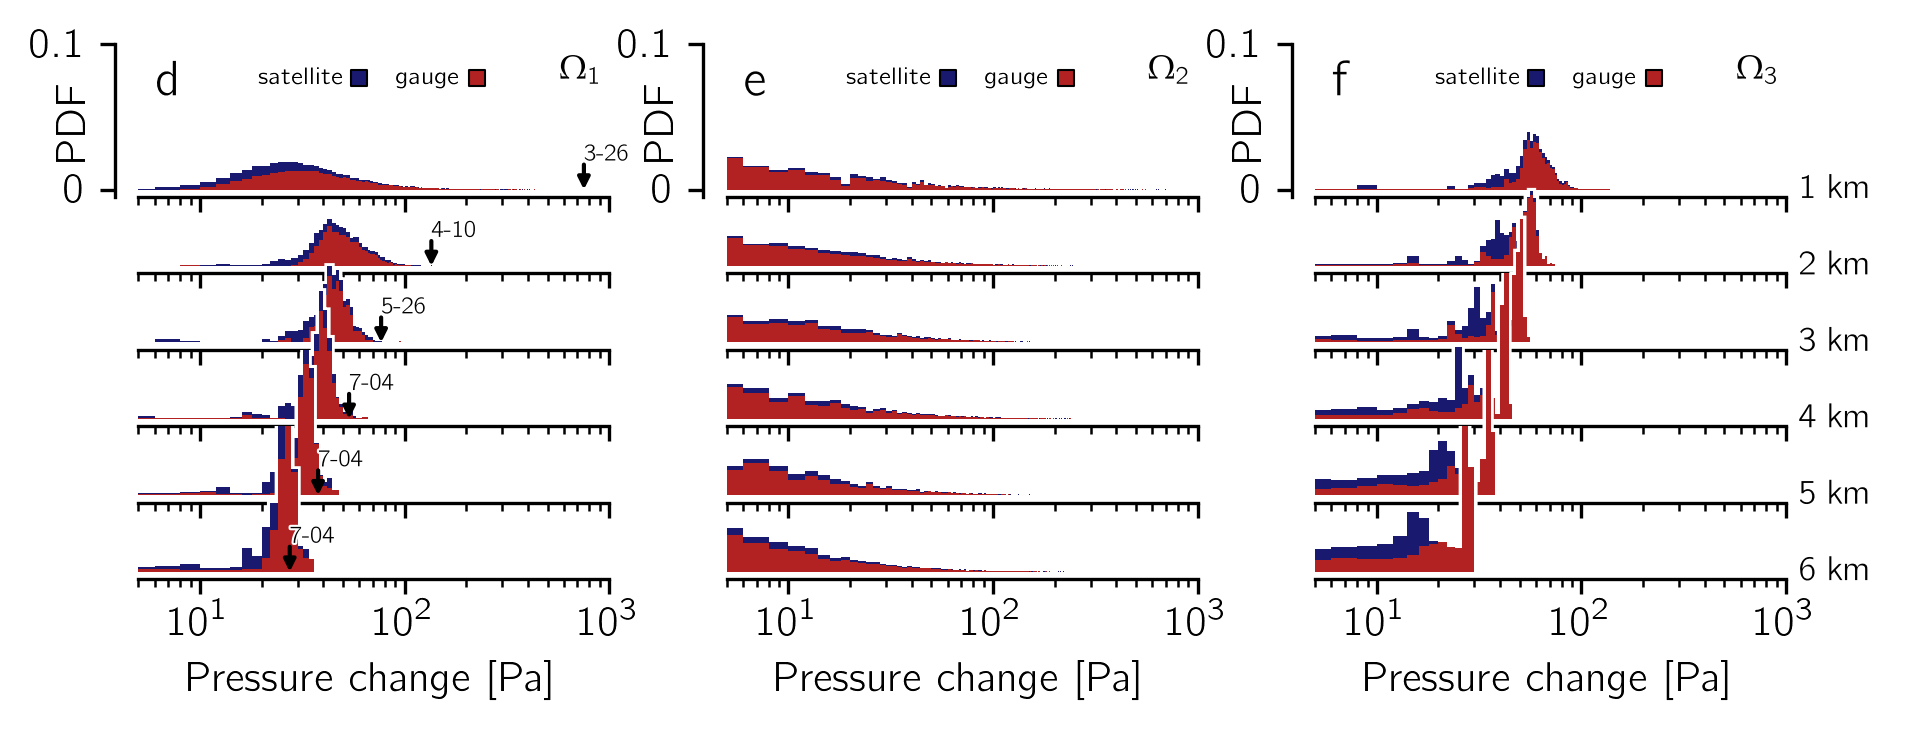

In [118]:
'''
Plots Extended Data Figure 2 [panels d--f]: Probability distribution functions of pressure change at different depths.
'''

fig = plt.figure(1, figsize=(mm2inch(180,60)), frameon=True, dpi=300)

gs = plt.GridSpec(6, 3, figure=fig, wspace=0.25, hspace=-.5
                 )
axs = [       
       fig.add_subplot((gs[0,0])),
       fig.add_subplot((gs[1,0])),
       fig.add_subplot((gs[2,0])),
       fig.add_subplot((gs[3,0])),
       fig.add_subplot((gs[4,0])),
       fig.add_subplot((gs[5,0])),
       
       fig.add_subplot((gs[0,1])),
       fig.add_subplot((gs[1,1])),
       fig.add_subplot((gs[2,1])),
       fig.add_subplot((gs[3,1])),
       fig.add_subplot((gs[4,1])),
       fig.add_subplot((gs[5,1])),
       
       fig.add_subplot((gs[0,-1])),
       fig.add_subplot((gs[1,-1])),
       fig.add_subplot((gs[2,-1])),
       fig.add_subplot((gs[3,-1])),
       fig.add_subplot((gs[4,-1])),
       fig.add_subplot((gs[5,-1])),
      ]


################# bgn panel d ###################
MAX = max(u_kx_lt[10])
MIN = 0
binwidth = 2
depths = [10,20,30, 40, 50 , 60]
m = 0
offset = 0
for z in depths:
    lt_p_data = u_3_stage_lt[z][:18680]
    u_data = u_3_stage[z]
    
    all_p_data = list(lt_p_data)
    all_p_data.extend(u_data)
    axs[m].hist(all_p_data, bins=np.arange(MIN,MAX + binwidth, binwidth),
                            density = True, histtype = "step", ec ="w", lw = 1.5)
    axs[m].hist([lt_p_data,u_data], 
                bins=np.arange(MIN,MAX + binwidth, binwidth),
        stacked=True, density=True, color = ["firebrick", "midnightblue"], lw = 0)
    
    axs[m].set_xlim(.5e1, 1e3)
    axs[m].set_ylim(-.005,0.1)
    axs[m].spines["right"].set_visible(False)
    axs[m].spines["top"].set_visible(False)
    axs[m].spines["left"].set_visible(False)
    axs[m].spines["left"].set_position(("axes", (offset-.05)))
    axs[m].set_yticks([0,0.1])
    axs[m].minorticks_on
    axs[m].set_xticklabels([])
    axs[m].tick_params(labelbottom=False)
    axs[m].tick_params(labelleft=False) 
    axs[m].tick_params(left= False)
    axs[m].annotate("{} km".format(int(z/10)), xy=(MAX,0),xycoords = "data",
                        xytext=(3, -2),textcoords='offset points',
                        fontsize = 'small', path_effects = buffer)
    axs[m].annotate('', xy=(max(u_3_stage[z][6515:6700]),0),
                xycoords = "data", fontsize = "xx-small",
                xytext=(0,8),textcoords='offset points',
            arrowprops={'arrowstyle': '-|>', 'color' : "k", 'shrinkB' : 0})
    
    alignments = ['none','right','left','left','left','left']
    date = str(file_dates[np.argmax(u_3_stage[z][6515:6700])+6515])[-4:]
    axs[m].annotate("{}".format(date), 
                    xy=(max(u_3_stage[z][6515:6700]),0.02),
                xycoords = "data", fontsize = 'xx-small', ha = 'left', path_effects = buffer)#ha = alignments[m])
    axs[m].set_xscale("log")
    axs[m].set_facecolor("None")
    m+=1
    offset+=.055
    
    ################# bgn panel e ###################
MAX = max(u_kx_lt[10])
MIN = 0
binwidth = 2
depths = [10,20,30, 40, 50 , 60]
# m = 0
offset = 0
for z in depths:
    lt_p_data = u_kx_lt[z][:18680]
    u_data = u_kx[z]
    
    all_p_data = list(lt_p_data)
    all_p_data.extend(u_data)
    axs[m].hist(all_p_data, bins=np.arange(MIN,MAX + binwidth, binwidth),
                            density = True, histtype = "step", ec ="w", lw = 1.5)
    axs[m].hist([lt_p_data,u_data],
                bins=np.arange(MIN,MAX + binwidth, binwidth),
        stacked=True, density=True, color = ["firebrick", "midnightblue"], lw = 0)
    
    axs[m].set_xlim(.5e1, 1e3)
    axs[m].set_ylim(-.005,0.1)
    axs[m].spines["right"].set_visible(False)
    axs[m].spines["top"].set_visible(False)
    axs[m].spines["left"].set_visible(False)
    axs[m].spines["left"].set_position(("axes", (offset-.05)))
    axs[m].set_yticks([0,0.1])
    axs[m].minorticks_on
    axs[m].set_xticklabels([])
    axs[m].tick_params(labelbottom=False)
    axs[m].tick_params(labelleft=False) 
    axs[m].tick_params(left= False)
    axs[m].annotate("{} km".format(int(z/10)), xy=(MAX,0),xycoords = "data",
                        xytext=(3, -2),textcoords='offset points',
                        fontsize = 'small', path_effects = buffer)

    alignments = ['none','right','left','left','left','left']
    date = str(file_dates[np.argmax(u_kx[z][6515:6700])+6515])[-4:]
    axs[m].set_xscale("log")
    axs[m].set_facecolor("None")
    m+=1
    offset+=.055
    
        ################# bgn panel f ###################
MAX = max(u_kx_lt[10])
MIN = 0
binwidth = 2
depths = [10,20,30, 40, 50 , 60]
# m = 0
offset = 0
for z in depths:
    lt_p_data = u_kg_lt[z][:18680]
    u_data = u_kg[z]
    
    all_p_data = list(lt_p_data)
    all_p_data.extend(u_data)
    axs[m].hist(all_p_data, bins=np.arange(MIN,MAX + binwidth, binwidth),
                            density = True, histtype = "step", ec ="w", lw = 1.5)
    axs[m].hist([lt_p_data,u_data], 
                bins=np.arange(MIN,MAX + binwidth, binwidth),
        stacked=True, density=True, color = ["firebrick", "midnightblue"], lw = 0)
    
    axs[m].set_xlim(.5e1, 1e3)
    axs[m].set_ylim(-.005,0.1)
    axs[m].spines["right"].set_visible(False)
    axs[m].spines["top"].set_visible(False)
    axs[m].spines["left"].set_visible(False)
    axs[m].spines["left"].set_position(("axes", (offset-.05)))

    axs[m].set_yticks([0,0.1])
    axs[m].minorticks_on
    axs[m].set_xticklabels([])
    axs[m].tick_params(labelbottom=False)
    axs[m].tick_params(labelleft=False) 
    axs[m].tick_params(left= False)
    alignments = ['none','right','left','left','left','left']
    date = str(file_dates[np.argmax(u_kg[z][6515:6700])+6515])[-4:]
    axs[m].set_xscale("log")
    axs[m].set_facecolor("None")
    axs[m].annotate("{} km".format(int(z/10)), xy=(1e3,0),xycoords = "data",
                        xytext=(3, -2),textcoords='offset points',
                        fontsize = 'small', path_effects = buffer)
    m+=1
    offset+=.055


for i in ([0,6,12]):
    axs[i].set_yticks([0,0.1]) 
    axs[i].tick_params(left= True)
    axs[i].tick_params(labelleft=True)
    axs[i].set_ylabel("PDF", labelpad=-15)
    axs[i].spines["left"].set_visible(True)
    axs[i].set_yticklabels([0,0.1]) 
    axs[i].scatter([],[], marker = 's',s=16, ec='k', lw = .5,color = 'midnightblue', label = 'satellite')
    axs[i].scatter([],[], marker = 's',s=16, ec='k', lw = .5, color = 'firebrick', label = 'gauge')
    axs[i].legend(fancybox = "None",edgecolor="None",
                  loc = 9,
                  facecolor = "w",
               markerfirst = False, framealpha=0., handlelength = 1,
              fontsize="xx-small", ncol=2, handletextpad=.25, columnspacing=1).set_zorder(12)

for i in [5,11,17]:
    axs[i].tick_params(labelbottom=True)
    axs[i].set_xlabel("Pressure change [Pa]")
    axs[i].tick_params(bottom= True)
    axs[i].xaxis.set_major_formatter(LogFormatterTexTextMode())
    axs[i].xaxis.set_major_locator(locmaj)
    axs[i].xaxis.set_minor_locator(locmin)
    
for num, label in enumerate(STRING.ascii_lowercase[3:6]):
    axs[num*6].annotate(label, (0, 1),xytext=(4, -4),
                      xycoords='axes fraction',textcoords='offset points',
    color='k',fontsize = 12, path_effects = buffer,ha='left', va='top', zorder = 1000)
    axs[num*6].annotate(r"$\Omega_{}$".format(num+1), (1, 1),xytext=(-12, -4),
                    xycoords='axes fraction',textcoords='offset points',
    color='k',fontsize = 8, path_effects = buffer,ha='left', va='top', zorder = 999)
    
plt.savefig("extended_data_fig_2-2.pdf", bbox_inches='tight') 
plt.savefig("extended_data_fig_2-2.png", bbox_inches='tight') 
plt.show()

**Extended Data Figure 2 |**  Model results. a Pore pressure change at 3 km below the surface (1.8 km b.s.l.) modelled over the period Jan 1950–Apr 2019 for model $\Omega_1$ (data shown since the 1975 Kalapana earthquake). Data modelled using gauge data are shown in red, data modelled using satellite data are blue. The 4-year averages (dashed lines) are also shown. Vertical bars indicate reported intrusion events within the rift zone. K = Kalapana earthquake; P = onset of Pu‘u ‘Ō‘ō eruption; E = 2018 fissure eruption. Arrow highlights the highest modelled pressure change. b As shown in a, but for model $\Omega_2$, a theoretical high-diffusivity end-member scenario. c As shown in a, but for model $\Omega_3$, a theoretical low-diffusivity end-member scenario. d Probability density function of modelled pressure change at depths 1—6 km below the surface from model $\Omega_1$. Arrows highlight pore pressure front diffusing from near surface (1 km) to greater depths over time. e As shown in d, but for model $\Omega_2$ (pressure maxima not shown). f As shown in d, but for model $\Omega_3$(pressure maxima not shown). 

In [105]:
'''
Subsets all eruption data (from all volcanoes listed in the Smithsonian's GVP database) into eruptions with a recorded start month. 
'''

all_eruption_months = all_active_volcanoes[all_active_volcanoes.StartDateMonth != 0]
all_eruption_months = all_eruption_months[pd.notnull(all_eruption_months['StartDateMonth'])]

In [106]:
'''
From initial volcanic eruption dataset, filters data according to data quality/ confidence.  
'''

import fnmatch
lst = list(set(all_eruption_months.Primary_Volcano_Type))
filtered = fnmatch.filter(lst, 'Sub*') ## Gets rid of submarine and subglacial eruptions

start_year = -10000 ## Defines data range of interest
end_year = 2020 ## Defines data range of interest

x1 = all_eruption_months[all_eruption_months["StartDateYear"] >= start_year] 
x1 = x1[x1["StartDateYear"] <= end_year]
x1 = x1.loc[~x1["Primary_Volcano_Type"].isin(filtered)]
x1 = x1[x1["Evidence_Category"] == 'Eruption Observed']
x1 = x1[x1["StartEvidenceMethod"] == 'Historical Observations']
x1 = x1[x1["Activity_Type"] == 'Confirmed Eruption']
x1a = x1[x1.StartDateDayUncertainty.isna()]
x1b = x1[x1.StartDateDayUncertainty <= 5.0]
x1 = pd.concat([x1a,x1b])


x2 = all_eruption_months_2[all_eruption_months_2["StartDateYear"] >= start_year]
x2 = x2[x2["StartDateYear"] <= end_year]
x2 = x2.loc[~x2["Primary_Volcano_Type"].isin(filtered)]
x2 = x2[x2["Evidence_Category"] == 'Eruption Observed']
x2 = x2[x2["StartEvidenceMethod"] == 'Historical Observations']
x2 = x2[x2["Activity_Type"] == 'Confirmed Eruption']
x2a = x2[x2.StartDateDayUncertainty.isna()]
x2b = x2[x2.StartDateDayUncertainty <= 5.0]
x2 = pd.concat([x2a,x2b])

x3 = all_eruption_months_3[all_eruption_months_3["StartDateYear"] >= start_year]
x3 = x3[x3["StartDateYear"] <= end_year]
x3 = x3.loc[~x3["Primary_Volcano_Type"].isin(filtered)]
x3 = x3[x3["Evidence_Category"] == 'Eruption Observed']
x3 = x3[x3["StartEvidenceMethod"] == 'Historical Observations']
x3 = x3[x3["Activity_Type"] == 'Confirmed Eruption']
x3a = x3[x3.StartDateDayUncertainty.isna()]
x3b = x3[x3.StartDateDayUncertainty <= 5.0]
x3 = pd.concat([x3a,x3b])
print('All eruptions: {}; VEI 2+: {}; VEI 3+: {}'.format(len(x1), len(x2), len(x3)))

x1 = x1.set_index('Volcano_Name')
x1 = x1.loc[[str(name_volc)]]

All eruptions: 4473; VEI 2+: 3309; VEI 3+: 789


In [107]:

'''
Concatenates and converts dates of all eruptions. 
Dates are assigned a NaT value if there are issues with leap years, mismatched dates,
or if the eruption occurs prior to the minimum Python Timestamp value [Timestamp('1677-09-21 00:12:43.145225')].
To avoid deletion of too many data, eruptions that have an accurate month and year
but *not* an accurate day are assigned a random day value between 1 and 31. 
This introduces artefacts, and should be analysed accordingly.
'''
import random


data_array = x1[x1['StartDateMonth'] != 0] 
data_array = data_array[pd.notnull(data_array['StartDateMonth'])]
q = 0
fixed_days = []
for l in data_array.StartDateDay:
    if l in range(1,32,1):
        fixed_days.append(l)
    else:
        q+=1
        fixed_days.append(random.randint(1, 31)) # artefact applies to 3 eruptions
data_array["fixed_days"] =  fixed_days

eruption_dates = pd.to_datetime(
    data_array.StartDateYear*10000
    +data_array.StartDateMonth*100
    +data_array.fixed_days,
    format='%Y%m%d', errors = 'coerce')
data_array['eruption_dates'] = eruption_dates
data_array['DOY'] = data_array['eruption_dates'].dt.dayofyear
total_eruptions = len(data_array)
 
print("done", q)

done 3


In [108]:
'''
Determines the wet and dry seasons (for Kilauea) based on particular spectral components. 
'''

time_frame = []
for j in range(0,len(rain_dates)):
    if rain_dates.date[:][j].year < 2019:
        time_frame.append(rain_dates.loc[j])
    elif rain_dates.date[:][j].month <3:
        time_frame.append(rain_dates.loc[j])
time_frame = pd.DataFrame(time_frame)

m = len(time_frame)

Y = np.fft.fft(time_frame.rainfall)
np.put(Y, range(9+1, m), 0.0) #i+1
ifft9 = np.fft.ifft(Y)
Y = np.fft.fft(time_frame.rainfall)
np.put(Y, range(18*2+1, m), 0.0) #i+1
ifft36 = np.fft.ifft(Y)   

harmonics = []
for j,k in enumerate(ifft9):
    if ifft36[j] <= k:
        harmonics.append(0)
    else:
        harmonics.append(1)

time_frame["harm"] = harmonics    

dayear = []
for j in time_frame.date:
    adate = dt.datetime.strptime(str(j),"%Y-%m-%d")
    day_of_year = adate.timetuple().tm_yday
    dayear.append(day_of_year)
time_frame["day"] = dayear    

grpd = time_frame.groupby(['day']).harm.agg(pd.Series.mean).to_frame(name = 'means').reset_index()


modes = []
for j, k in enumerate(grpd.means):
        if k >= 0.5:
            modes.append(1)
        else:
            modes.append(0)
grpd['modes'] = pd.DataFrame(modes)

rainy = []
dry = []
for j in grpd.modes:
    if j != 0:
        rainy.append(1)
    else:
        dry.append(1)
sum_rainy = sum(rainy)
sum_dry = sum(dry)

seasons = []
for j,k in enumerate(data_array.DOY.values):
    seasons.append(grpd.modes[k-1])
data_array['season'] = seasons


rainy_eruptions = 0
dry_eruptions = 0
for j,k in enumerate(data_array.DOY.values):
    if data_array.season.values[j] == 0:
        dry_eruptions += 1
    else:
        rainy_eruptions += 1
print("done")

done


In [109]:
'''
Probability of a given day being in the "wet" season
'''
P = sum_rainy/365.25
print("Probability : {:.2}".format(P))

Probability : 0.47


In [110]:
'''
Same analysis, but only including eruptions VEI 2 and greater
'''
data_array2 = data_array[data_array.ExplosivityIndexMax >= 2]

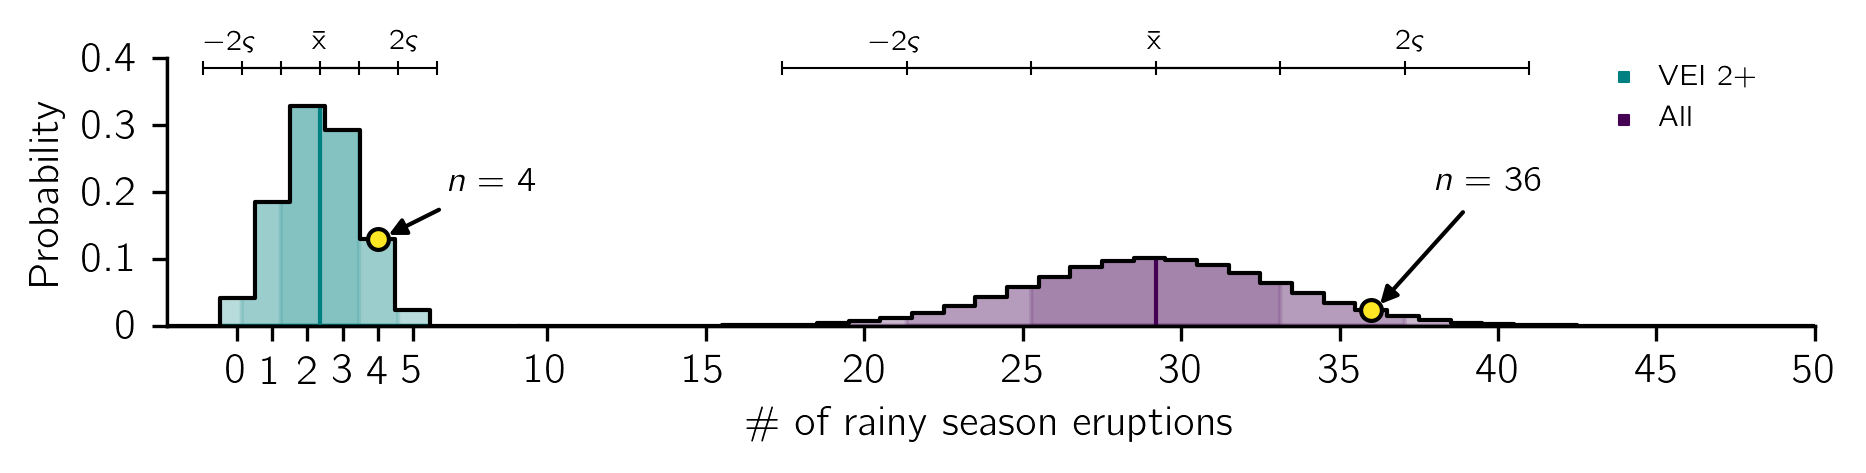

In [113]:
'''
Plots Extended Data Figure 3: Binomial probability distribution of "wet" versus "dry" eruptions at Kilauea,
including all eruptions and those VEI 2 and greater.
'''
# '''
# Binomial probability distribution
# '''
from scipy.stats import binom

n = total_eruptions
r = rainy_eruptions
nr = n-r
Px = float((Decimal(fact(n))/Decimal((fact(r))*Decimal(fact(nr))))*Decimal(P**r)*Decimal((1-P)**nr))
mu = n*P
sig2 = mu*(1-P)
sigma = sig2**0.5

s1 = mu-sigma
s2 = mu+sigma
s3 = mu-(2*sigma)
s4 = mu+(2*sigma)
s5 = mu-(3*sigma)
s6 = mu+(3*sigma)
s7 = mu-(4*sigma)
s8 = mu+(4*sigma)

dist = binom(n, P)
x = np.arange(-5, total_eruptions+4,1)
xx = np.arange(mu-sigma, mu+sigma, 0.01)
y2 = dist.pmf(xx)

fig = plt.figure(1, figsize=(mm2inch(180,30)), frameon=True, dpi=300)
ax = fig.add_subplot(111)
plt.plot(x, dist.pmf(x), c='black',
                 label=r'$p=%.1f,\ n=%i$' % (P, n), linestyle='steps-mid', zorder = 990, linewidth = 1)

y1 = dist.pmf(x)
yy = np.arange(0,0.8 ,0.001)
ax.fill_between(x, 1., y1,facecolor = "white",edgecolor = "None", step='mid')
ax.fill_betweenx(y=yy, x1 = s1, x2=s2, color = vir_g, alpha = 0.15, zorder = 0)
ax.fill_betweenx(y=yy, x1 = s3, x2=s4, color = vir_g, alpha = 0.15, zorder = 0)
ax.fill_betweenx(y=yy, x1 = s5, x2=s6, color = vir_g, alpha = 0.15, zorder = 0)
ax.fill_betweenx(y=yy, x1 = s7, x2=s8, color = vir_g, alpha = 0.15, zorder = 0)


mean_line = plt.axvline(x=mu, color = vir_g, zorder = 0, linewidth = 1)
obs = ax.scatter(r,Px,marker = 'o', edgecolor = 'k',color=vir_y,s=25, zorder = 999, clip_on = False)

ax.set_ylabel(r'Probability', fontsize = 10)
ax.set_xlabel('\# of rainy season eruptions')

ax.set_yticks(np.arange(0,1,0.1))
ax.set_xticks(np.arange(0,total_eruptions+10,10))

ax.hlines(xmin = (mu-sigma),xmax=(mu+sigma), y=0.385, linewidth = 0.5)
ax.hlines(xmin = (mu-2*sigma),xmax=(mu+2*sigma), y=0.385, linewidth = 0.5)
ax.hlines(xmin = (mu-3*sigma),xmax=(mu+3*sigma), y=0.385, linewidth = 0.5)
ax.vlines(x = (mu-sigma), ymin = 0.375, ymax = 0.395, linewidth = 0.5)
ax.vlines(x = (mu+sigma), ymin = 0.375, ymax = 0.395, linewidth = 0.5)
ax.vlines(x = (mu-2*sigma), ymin = 0.375, ymax = 0.395, linewidth = 0.5)
ax.vlines(x = (mu+2*sigma), ymin = 0.375, ymax = 0.395, linewidth = 0.5)
ax.vlines(x = (mu-3*sigma), ymin = 0.375, ymax = 0.395, linewidth = 0.5)
ax.vlines(x = (mu+3*sigma), ymin = 0.375, ymax = 0.395, linewidth = 0.5)
ax.vlines(x = (mu), ymin = 0.375, ymax = 0.395, linewidth = 0.5)

ax.annotate(r"\={x}",
             (mu,0.4),
            xytext=(-2, 2),
            xycoords='data',
            textcoords='offset points',
            color='k',
            fontsize = "x-small",
            )
ax.annotate(r"$2 \varsigma$",
             (mu+2*sigma,0.4),
            xytext=(-2, 2),
            xycoords='data',
            textcoords='offset points',
            color='k',
            fontsize = "x-small",
            )
ax.annotate(r"$-2 \varsigma$",
             (mu-2*sigma,0.4),
            xytext=(-9, 2),
            xycoords='data',
            textcoords='offset points',
            color='k',
            fontsize = "x-small",
            )
ax.annotate('$n =$ {}'.format(int(r)), xy=(r+0.1,Px), xytext=(r+2,0.2),
            arrowprops={'arrowstyle': '-|>', 'color': 'k'}, zorder = 10, alpha = 1., fontsize = "small")

ax1 = ax.twiny()
n = len(data_array2)
r = len(data_array2[data_array2.season != 0])
nr = n-r
Px = float((Decimal(fact(n))/Decimal((fact(r))*Decimal(fact(nr))))*Decimal(P**r)*Decimal((1-P)**nr))
mu = n*P
sig2 = mu*(1-P)
sigma = sig2**0.5

s1 = mu-sigma
s2 = mu+sigma
s3 = mu-(2*sigma)
s4 = mu+(2*sigma)
s5 = mu-(3*sigma)
s6 = mu+(3*sigma)
s7 = mu-(4*sigma)
s8 = mu+(4*sigma)

dist = binom(n, P)
x = np.arange(-5, n+4,1)
xx = np.arange(mu-sigma, mu+sigma, 0.01)
y2 = dist.pmf(xx)

plt.plot(x, dist.pmf(x), c='black',
                 label=r'$p=%.1f,\ n=%i$' % (P, n), linestyle='steps-mid', zorder = 990, linewidth = 1)

y1 = dist.pmf(x)
yy = np.arange(0,0.8 ,0.001)
ax1.fill_between(x, 1., y1,facecolor = "white",edgecolor = "None", step='mid')
ax1.fill_betweenx(y=yy, x1 = s1, x2=s2, color = "teal", alpha = 0.15, zorder = 0)
ax1.fill_betweenx(y=yy, x1 = s3, x2=s4, color = "teal", alpha = 0.15, zorder = 0)
ax1.fill_betweenx(y=yy, x1 = s5, x2=s6, color = "teal", alpha = 0.15, zorder = 0)
ax1.fill_betweenx(y=yy, x1 = s7, x2=s8, color = "teal", alpha = 0.15, zorder = 0)


mean_line = ax1.axvline(x=mu, color = "teal", zorder = 0, linewidth = 1)
obs = ax1.scatter(r,Px,marker = 'o', edgecolor = 'k',color=vir_y,s=25, zorder = 999, clip_on = False)

ax1.set_yticks(np.arange(0,1,0.1))
ax1.set_xticks(np.arange(0,n+10,10))

ax1.hlines(xmin = (mu-sigma),xmax=(mu+sigma), y=0.385, linewidth = 0.5)
ax1.hlines(xmin = (mu-2*sigma),xmax=(mu+2*sigma), y=0.385, linewidth = 0.5)
ax1.hlines(xmin = (mu-3*sigma),xmax=(mu+3*sigma), y=0.385, linewidth = 0.5)
ax1.vlines(x = (mu-sigma), ymin = 0.375, ymax = 0.395, linewidth = 0.5)
ax1.vlines(x = (mu+sigma), ymin = 0.375, ymax = 0.395, linewidth = 0.5)
ax1.vlines(x = (mu-2*sigma), ymin = 0.375, ymax = 0.395, linewidth = 0.5)
ax1.vlines(x = (mu+2*sigma), ymin = 0.375, ymax = 0.395, linewidth = 0.5)
ax1.vlines(x = (mu-3*sigma), ymin = 0.375, ymax = 0.395, linewidth = 0.5)
ax1.vlines(x = (mu+3*sigma), ymin = 0.375, ymax = 0.395, linewidth = 0.5)
ax1.vlines(x = (mu), ymin = 0.375, ymax = 0.395, linewidth = 0.5)

ax1.annotate(r"\={x}",
             (mu,0.4),
            xytext=(-2, 2),
            xycoords='data',
            textcoords='offset points',
            color='k',
            fontsize = "x-small",
            )
ax1.annotate(r"$2 \varsigma$",
             (mu+2*sigma,0.4),
            xytext=(-2, 2),
            xycoords='data',
            textcoords='offset points',
            color='k',
            fontsize = "x-small",
            )
ax1.annotate(r"$-2 \varsigma$",
             (mu-2*sigma,0.4),
            xytext=(-9, 2),
            xycoords='data',
            textcoords='offset points',
            color='k',
            fontsize = "x-small",
            )
ax1.annotate('$n =$ {}'.format(int(r)), xy=(r+0.1,Px), xytext=(r+2,0.2),
            arrowprops={'arrowstyle': '-|>', 'color': 'k'}, zorder = 10, alpha = 1., fontsize = "small")

ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x))
ax.yaxis.set_major_formatter(ticks)
ax.xaxis.set_major_formatter(ticks)
ax1.xaxis.set_major_formatter(ticks)
ax.set_ylim([0.,0.4])
ax1.set_ylim([0.,0.4])
# ax1.set_yticks([])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

ax.set_xlim([-2,45])
ax1.set_xlim([-2,45])
ax1.set_xticks(np.arange(0,6,1))
ax.set_xticks(np.arange(10,51,5))

ax1.xaxis.tick_bottom()
ax1.xaxis.set_label_position('bottom') 

marker_1 = plt.scatter([],[], marker = 's', s=5, color = "teal", edgecolors="teal",linewidth = 0.5,  label = "VEI 2+")
marker_2 = plt.scatter([],[], marker = 's', s=5, color = vir_g, edgecolors=vir_g,linewidth = 0.5,  label = "All")

legend = plt.legend([marker_1, marker_2],['VEI 2+', 'All'],fontsize = "x-small", edgecolor = "None", fancybox="None",
                    markerscale = 1, handlelength = 0.7, loc='upper right', bbox_to_anchor=(0.98, 1.08),
                   framealpha=0)
legend.get_frame().set_linewidth(0.8)

plt.savefig("../figures/kil_fig_s2.png", bbox_inches='tight')
plt.savefig("../figures/kil_fig_s2.pdf", bbox_inches='tight')

plt.show()

**Extended Data Figure 3| Predicted binomial distribution for “wet” season eruptions at Kīlauea.** The anticipated mean $\overline{x}$ and standard deviations $\varsigma$ are shown. The observed number of historical wet season eruptions (36) is highlighted, with a probability of 0.04. 